<a href="https://colab.research.google.com/github/kumararpan0820/Environmental-Monitoring-Pollution-Control/blob/main/Environmental_Monitoring_%26_Pollution_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install us

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 4.4 MB/s eta 0:00:00


In [2]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import us # !pip install us
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from typing import Callable, Union, Optional, List

# Nice visualization
import plotly.express as px

# Global variables
FIGSIZE = (18, 10)

# Data Visualization updates
plt.rcParams["figure.figsize"] = FIGSIZE
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', None)

%config InlineBackend.figure_format = 'retina'

In [3]:
# Importing data set
df = pd.read_csv('/content/pollution_2000_2022.csv', index_col=0)
df.Date = pd.to_datetime(df.Date)

# Remove leading and trailing spaces from string before mappings
cols_to_strip = ['Address', 'State', 'County', 'City']
df[cols_to_strip] = df[cols_to_strip].apply(lambda x: x.str.strip())

# Getting state to abbreviation dictionary
state_abbreviation_map = {state.name: state.abbr for state in us.states.STATES}

# Looking for missing state name
for value in df.State.unique():
    if value not in state_abbreviation_map.keys():
        print(f'Missing: {value}')

Missing: District Of Columbia


In [4]:
# Abbrivating state names and adding D.C
state_abbreviation_map['District Of Columbia'] = 'DC' # adding washington D.C.

# Mapping stats to abbreviation
df['State'] = df['State'].map(state_abbreviation_map)

# Showing updated dataframe
display(df.head())

Date                                  Address State    County  \
0 2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   
1 2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   
2 2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   
3 2000-01-04  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   
4 2000-01-05  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   

      City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI   CO Mean  \
0  Phoenix  0.019765             0.040               10      37  0.878947   
1  Phoenix  0.015882             0.032               10      30  1.066667   
2  Phoenix  0.009353             0.016                9      15  1.762500   
3  Phoenix  0.015882             0.033                9      31  1.829167   
4  Phoenix  0.007353             0.012                9      11  2.700000   

   CO 1st Max Value  CO 1st Max Hour  CO AQI  SO2 Mean  SO2 1st Max Value  \
0               2.2               23    25.0  3.000000                9.0   
1               2.3                0    26.0  1.958333                3.0   
2               2.5                8    28.0  5.250000               11.0   
3               3.0               23    34.0  7.083333               16.0   
4               3.7                2    42.0  8.708333               15.0   

   SO2 1st Max Hour  SO2 AQI   NO2 Mean  NO2 1st Max Value  NO2 1st Max Hour  \
0                21     13.0  19.041667               49.0                19   
1                22      4.0  22.958333               36.0                19   
2                19     16.0  38.125000               51.0                 8   
3                 8     23.0  40.260870               74.0                 8   
4                 7     21.0  48.450000               61.0                22   

   NO2 AQI  
0       46  
1       34  
2       48  
3       72  
4       58

In [5]:
# Showing general data info
print( df.info() )

<class 'pandas.core.frame.DataFrame'>
Index: 647251 entries, 0 to 647250
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               647251 non-null  datetime64[ns]
 1   Address            647251 non-null  object        
 2   State              647251 non-null  object        
 3   County             647251 non-null  object        
 4   City               647251 non-null  object        
 5   O3 Mean            647251 non-null  float64       
 6   O3 1st Max Value   647251 non-null  float64       
 7   O3 1st Max Hour    647251 non-null  int64         
 8   O3 AQI             647251 non-null  int64         
 9   CO Mean            647251 non-null  float64       
 10  CO 1st Max Value   647251 non-null  float64       
 11  CO 1st Max Hour    647251 non-null  int64         
 12  CO AQI             647251 non-null  float64       
 13  SO2 Mean           647251 non-null  float64      

In [6]:
# Main data summary
data_description = df.drop(columns=['Date']).describe().iloc[1:, :].round(3)
display( data_description.T.style.background_gradient(cmap='Greys') )

In [7]:
# Getting certain columns names for EDA later
columns_of_interest = ['Date', 'State'] + list(df.columns)[5:-3]
numeric_columns = [column for column in df.columns if np.issubdtype(df[column].dtype, np.number)]
mean_columns = list(df.columns)[0:5] + [column for column in df.columns if 'Mean' in column]
hour_columns = list(df.columns)[0:5] + [column for column in df.columns if 'Hour' in column]
value_columns = list(df.columns)[0:5] + [column for column in df.columns if 'Value' in column]
aqi_columns = list(df.columns)[0:5] + [column for column in df.columns if 'AQI' in column]

column_objects = dict(mean=mean_columns,
                      hour=hour_columns,
                      value=value_columns,
                      aqi=aqi_columns)

# Looking at time and states in dataset
years = df.Date.dt.year.unique()
states = df.State.unique()
print(f'Years in the Ddata set:\n{years}\n')
print(f'States in the Ddata set:\n{sorted(states)}')

Years in the Ddata set:
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]

States in the Ddata set:
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WY']


In [8]:
# Adding time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

display(df.head(3))

Date                                  Address State    County  \
0 2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   
1 2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   
2 2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN    AZ  Maricopa   

      City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI   CO Mean  \
0  Phoenix  0.019765             0.040               10      37  0.878947   
1  Phoenix  0.015882             0.032               10      30  1.066667   
2  Phoenix  0.009353             0.016                9      15  1.762500   

   CO 1st Max Value  CO 1st Max Hour  CO AQI  SO2 Mean  SO2 1st Max Value  \
0               2.2               23    25.0  3.000000                9.0   
1               2.3                0    26.0  1.958333                3.0   
2               2.5                8    28.0  5.250000               11.0   

   SO2 1st Max Hour  SO2 AQI   NO2 Mean  NO2 1st Max Value  NO2 1st Max Hour  \
0                21     13.0  19.041667               49.0                19   
1                22      4.0  22.958333               36.0                19   
2                19     16.0  38.125000               51.0                 8   

   NO2 AQI  Year  Month  Day  
0       46  2000      1    1  
1       34  2000      1    2  
2       48  2000      1    3

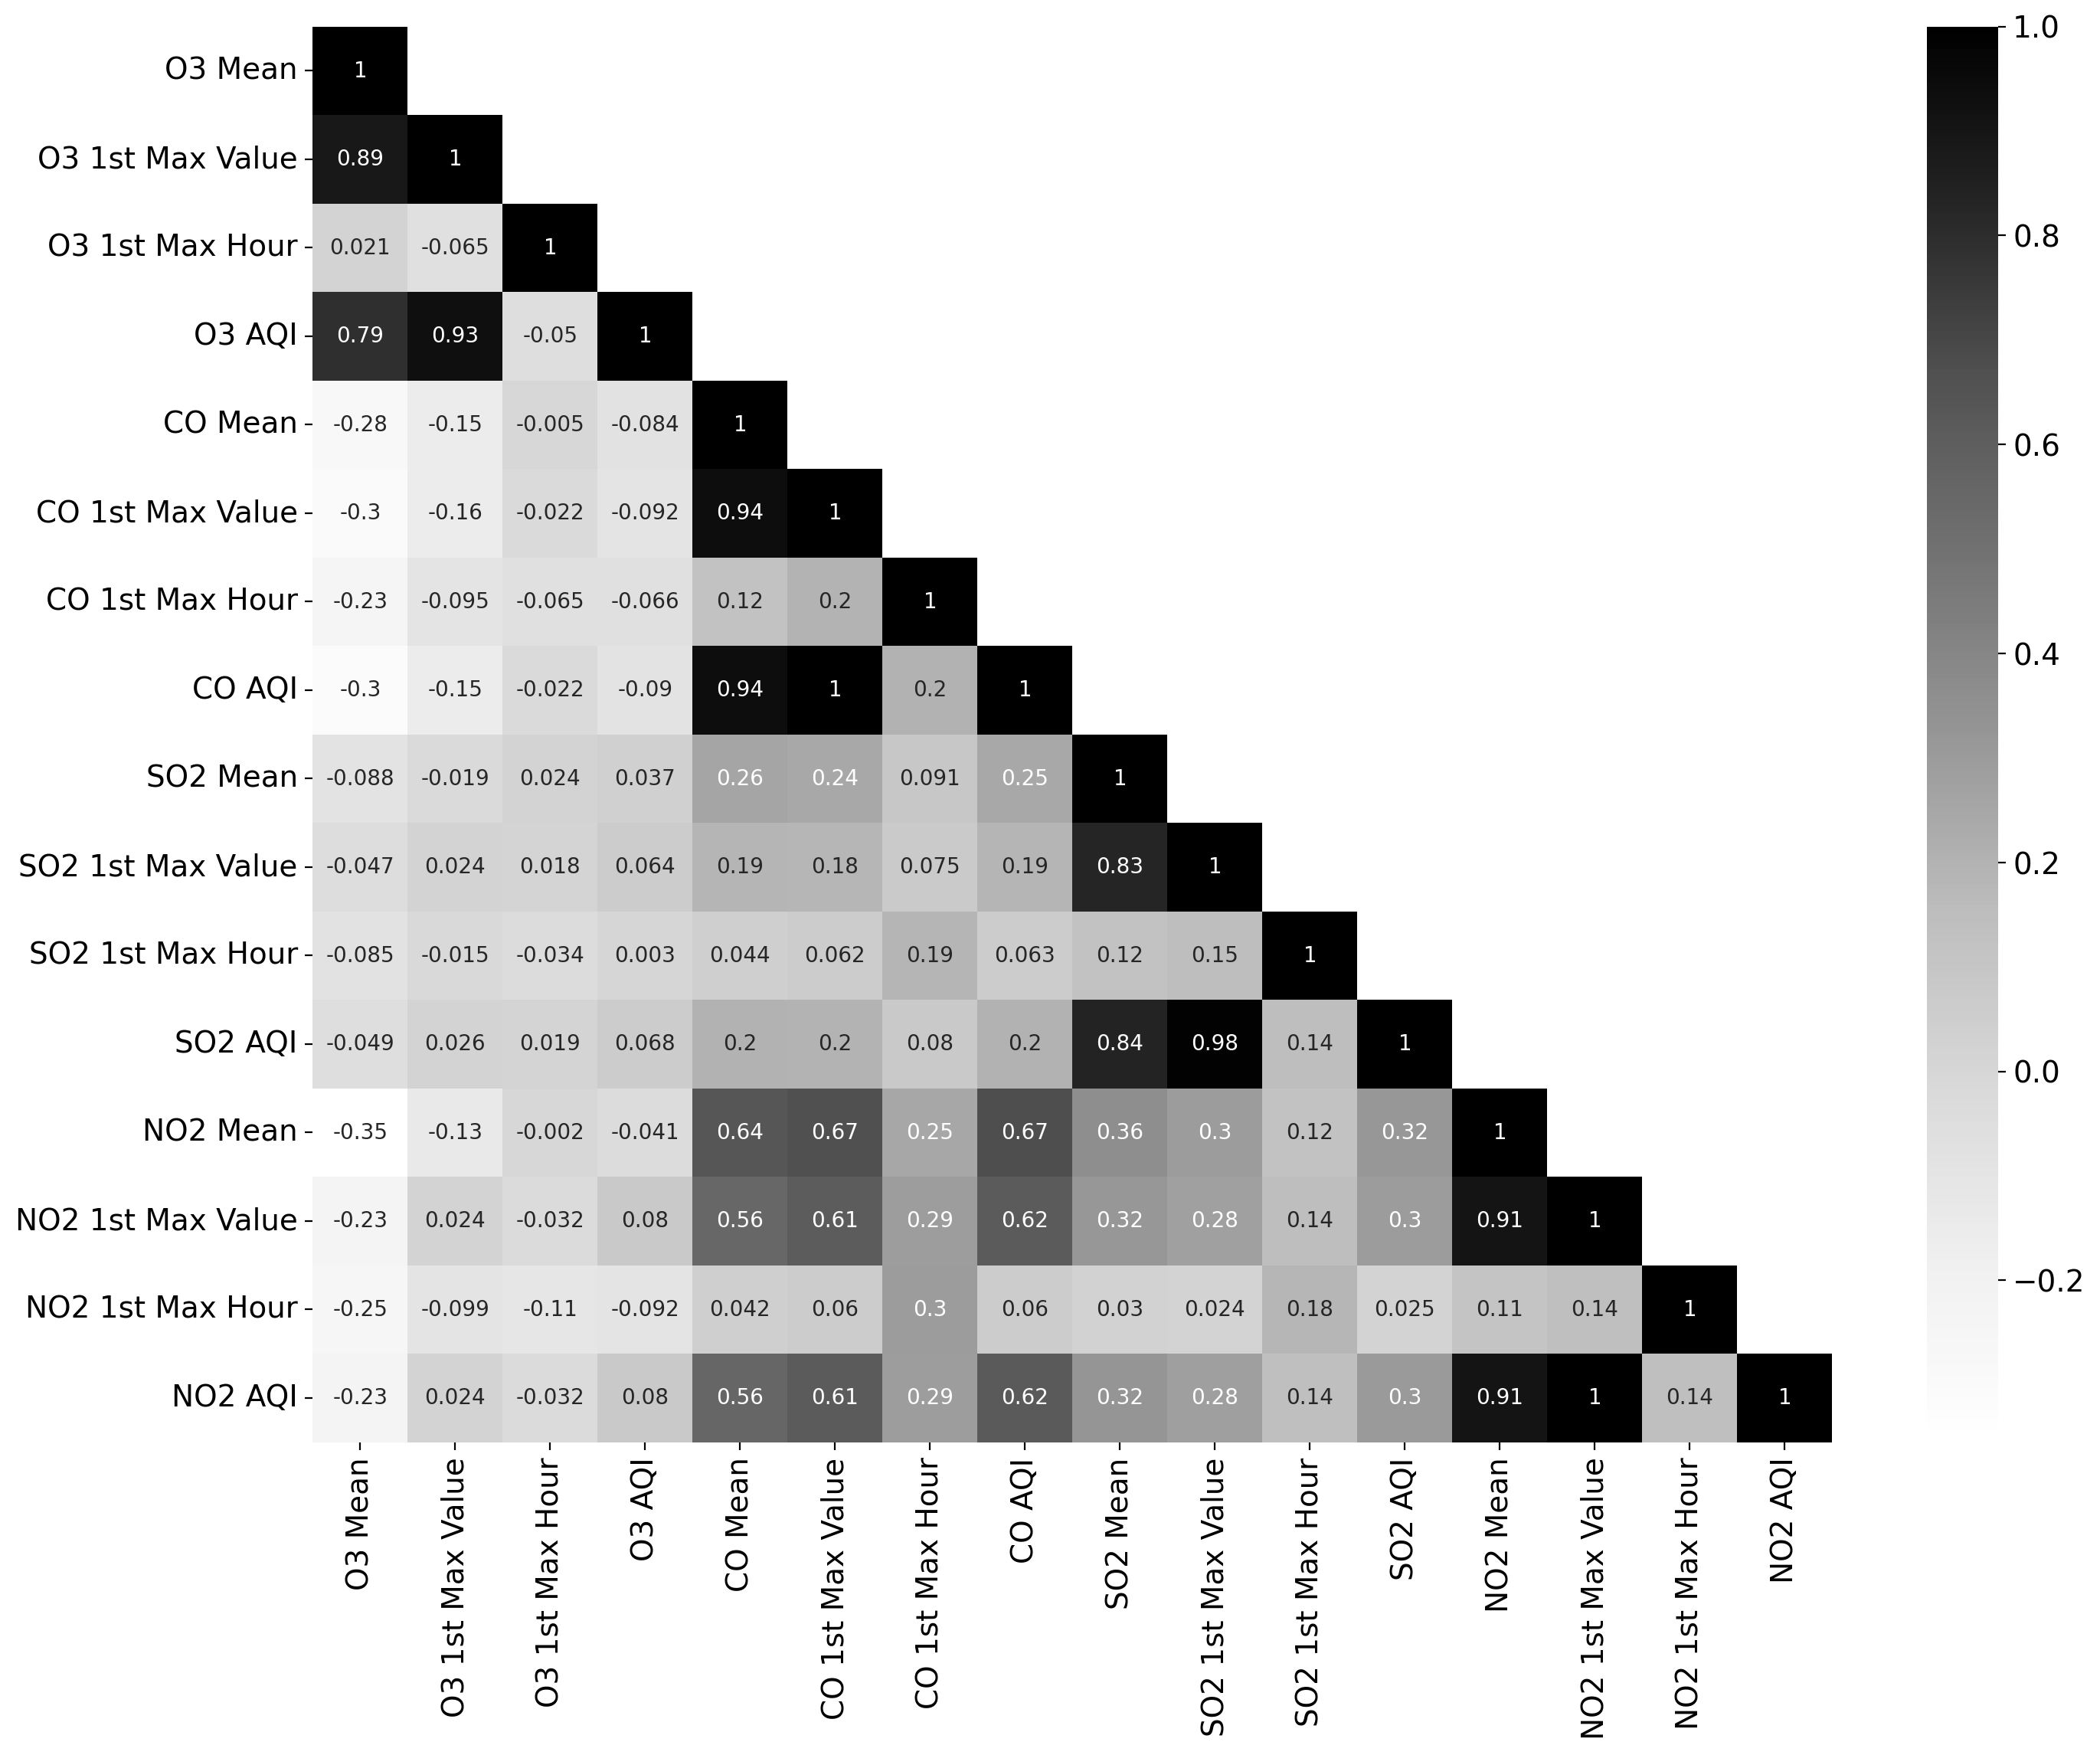

In [9]:
# Looking at entire correlation table
plt.figure(figsize=(16,12))
correlation_matrix = df.drop(columns=['Day', 'Month', 'Year']).corr(numeric_only=True).round(3)
sns.heatmap(correlation_matrix, mask=np.triu(correlation_matrix, 1), annot=True, cmap='Greys', annot_kws={"size": 10})
plt.show()

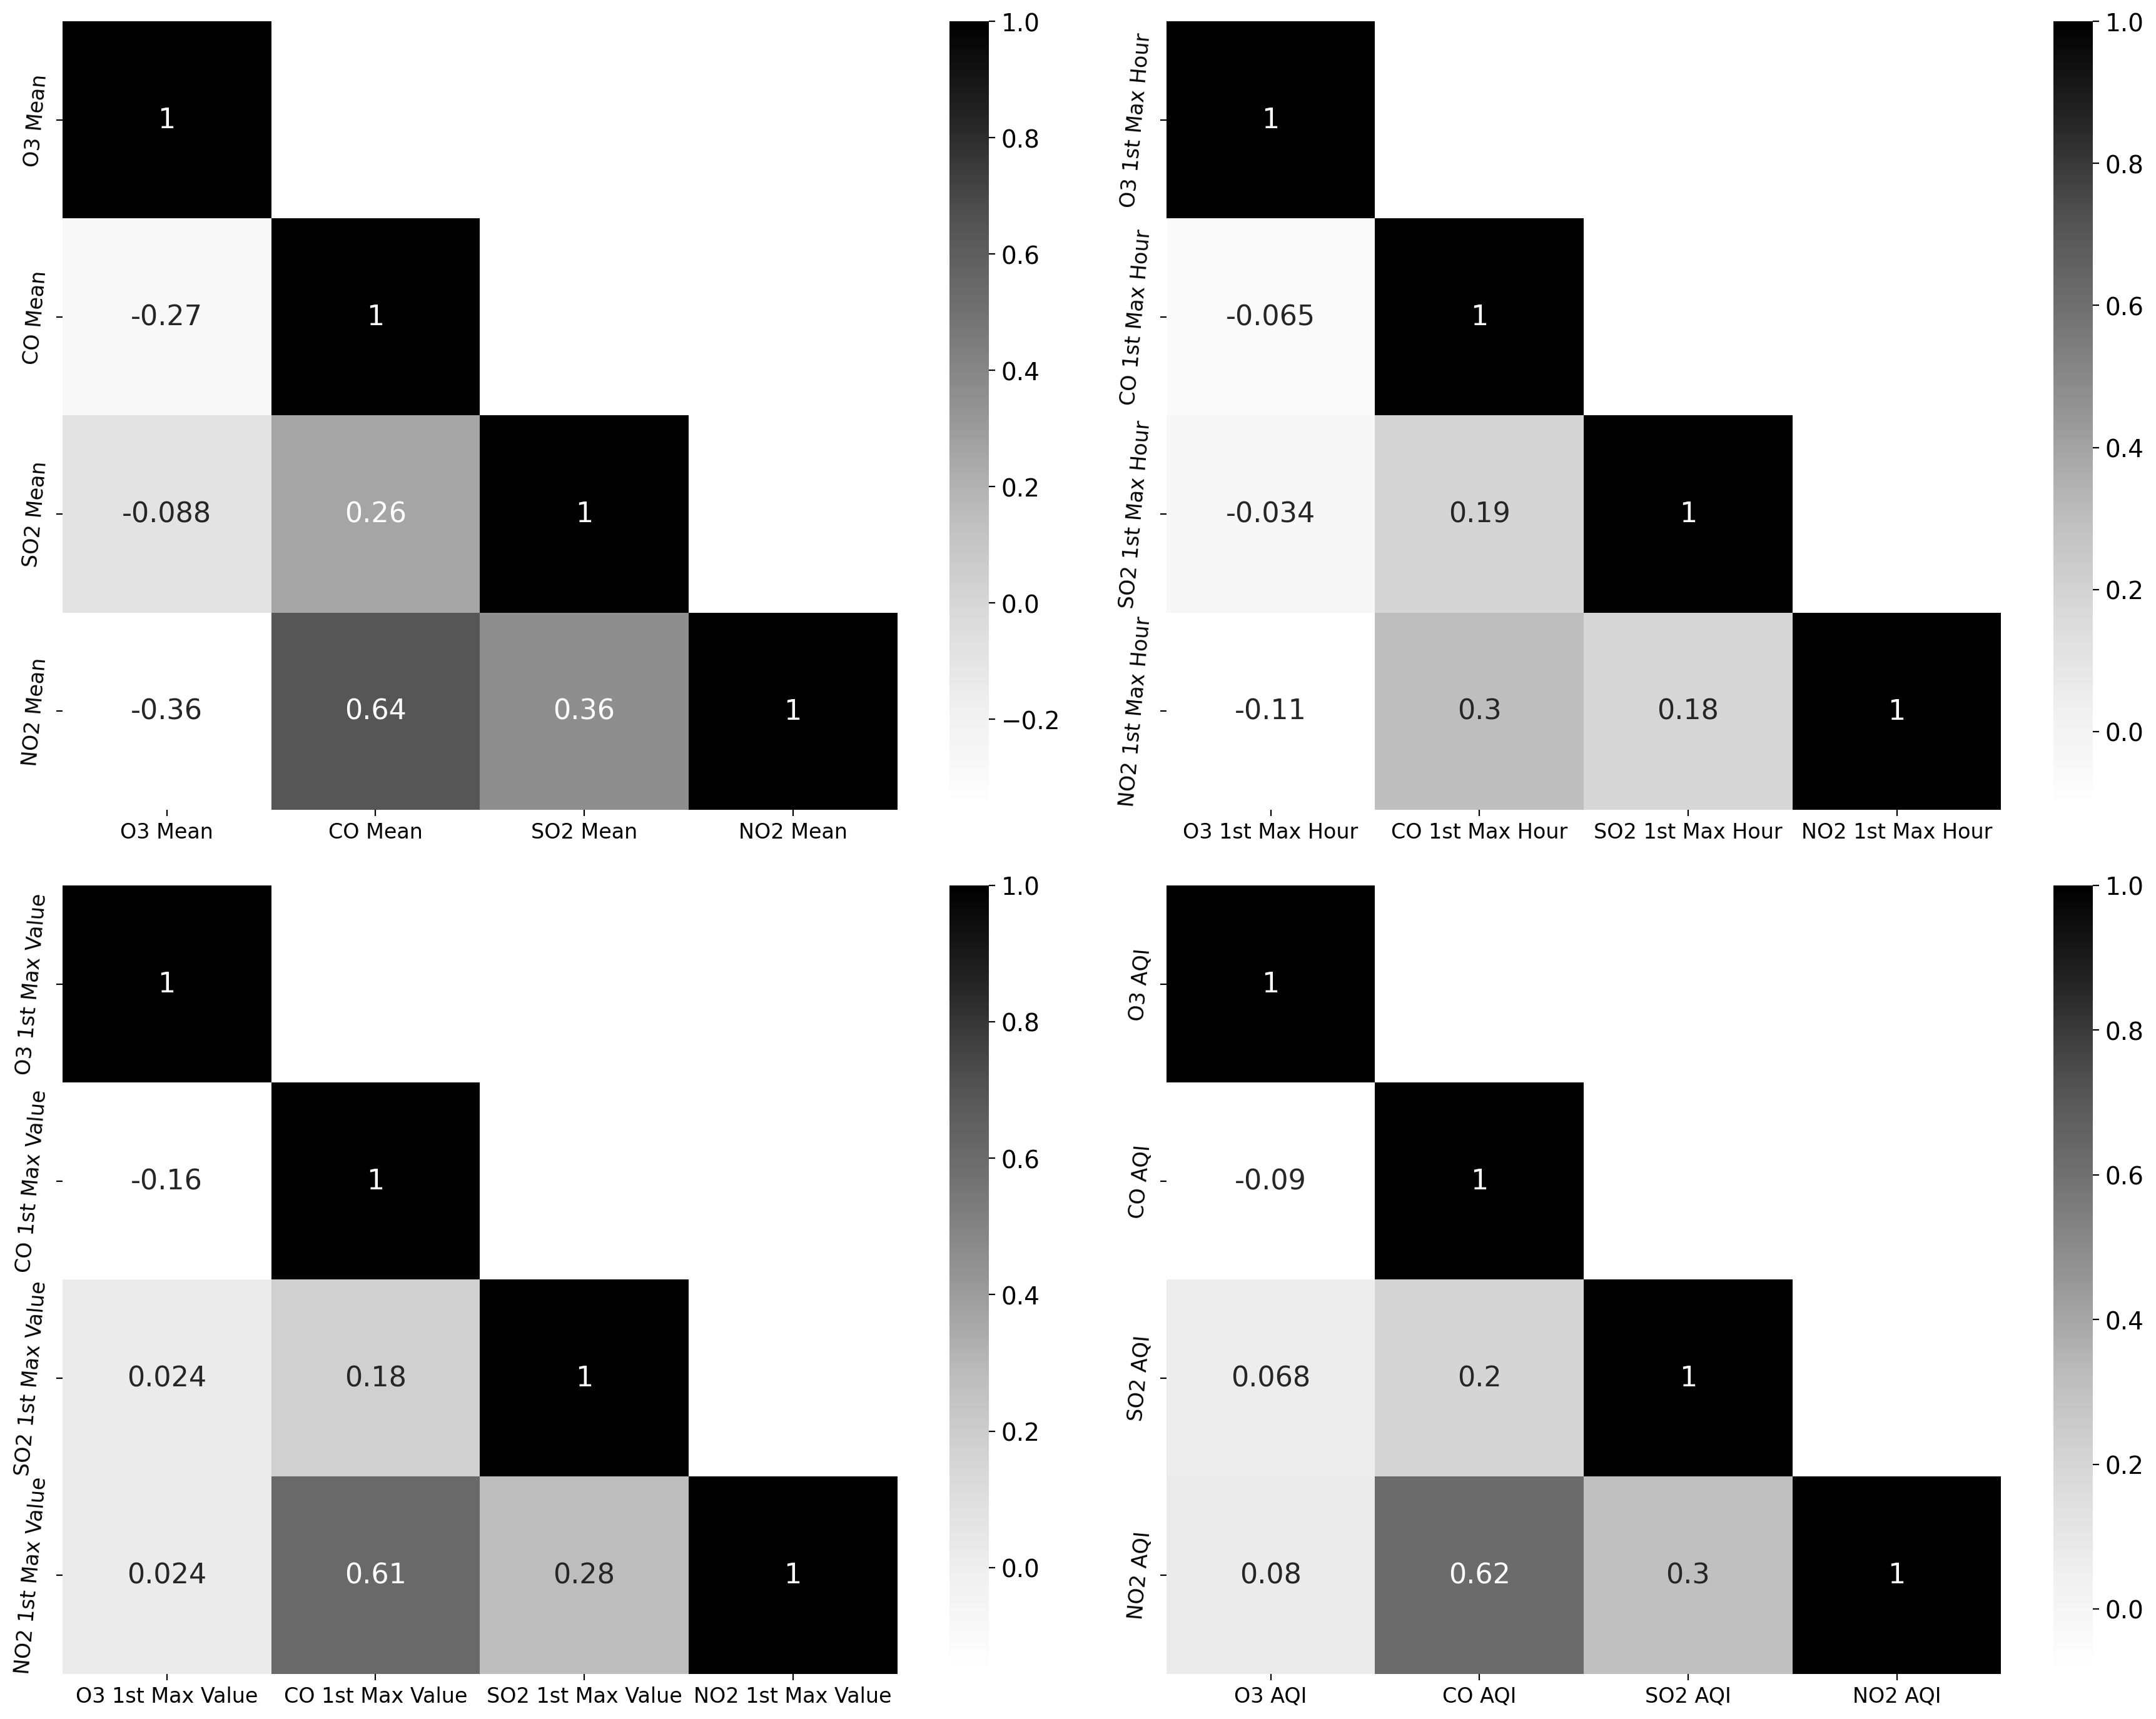

In [10]:
# Aggregating correlation for a closer look
fig, ax = plt.subplots(2, 2, figsize=(18, 14))
ax = ax.flatten()

for i, columns in enumerate(column_objects.values()):

    # Correlation matrix
    correlation_matrix = df[columns].corr(numeric_only=True)
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='Greys',
                mask=np.triu(correlation_matrix, 1),
                annot_kws={"size": 16},
                ax=ax[i])
    ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=85, fontsize=12)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

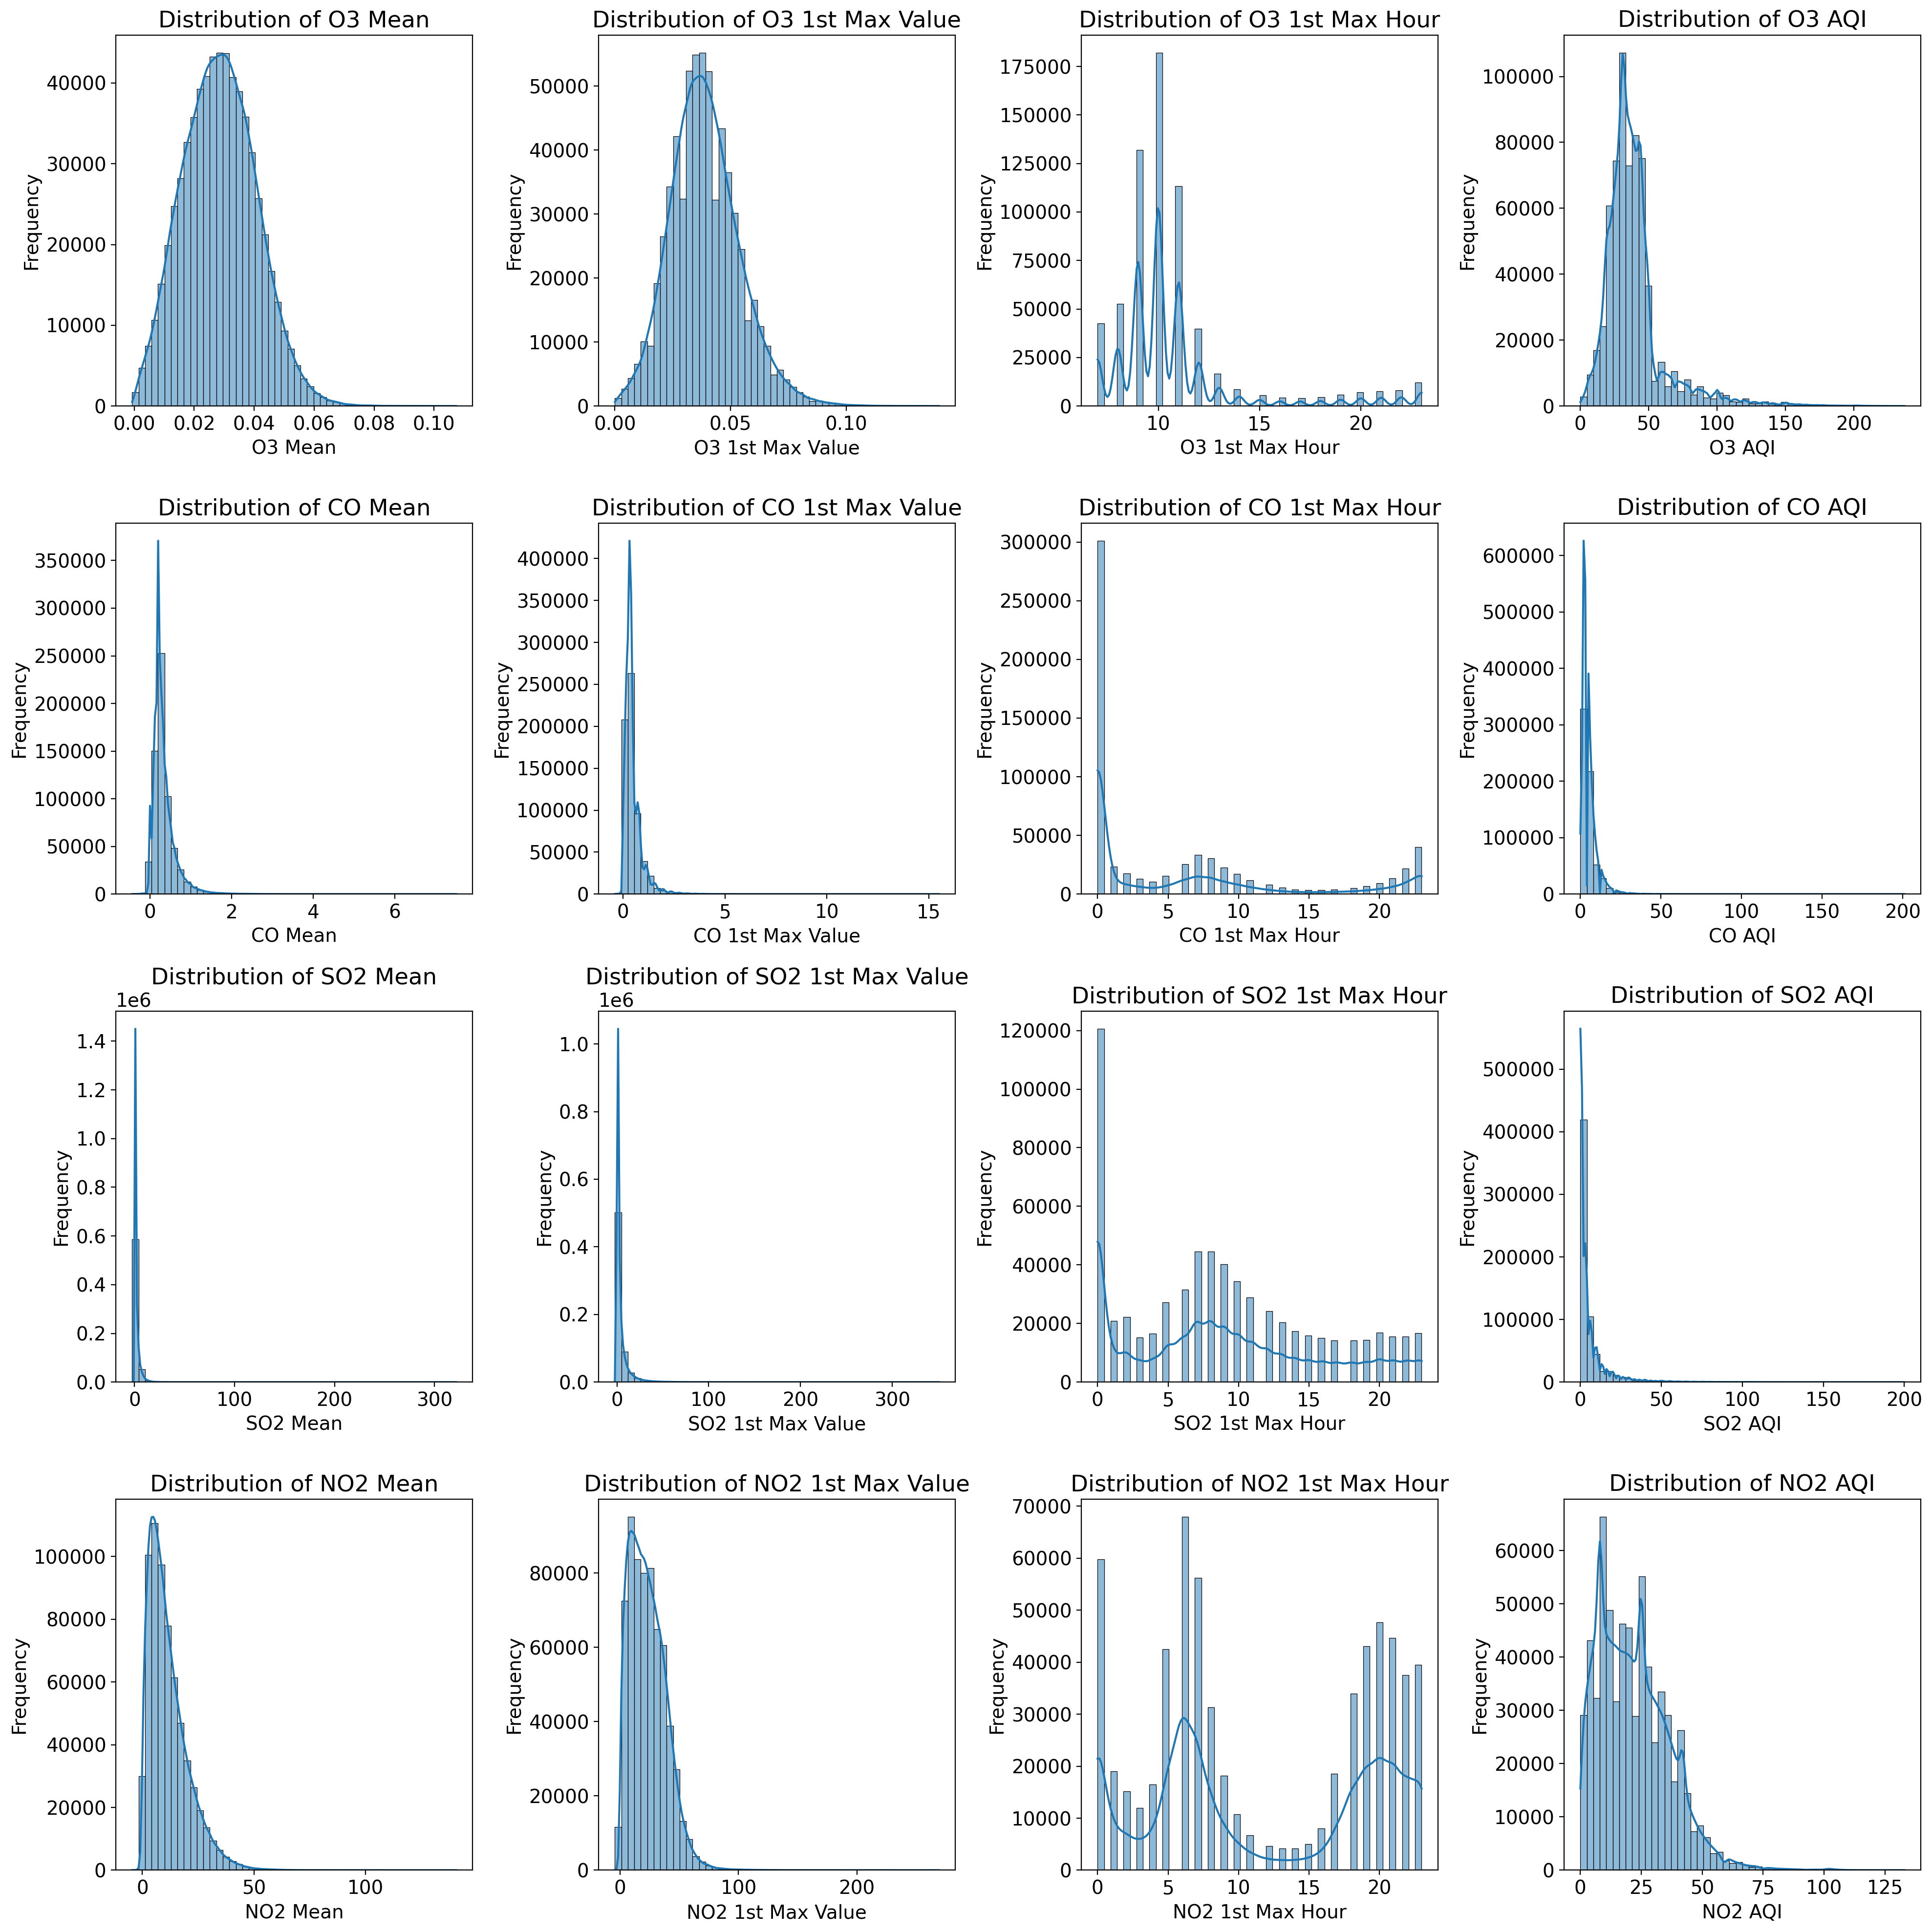

In [15]:
# General distributions of gases
histo_plotter(df, numeric_columns, bins=50)

/tmp/ipython-input-4238129780.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()
/tmp/ipython-input-4238129780.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()
/tmp/ipython-input-4238129780.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()
/tmp/ipython-input-4238129780.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()


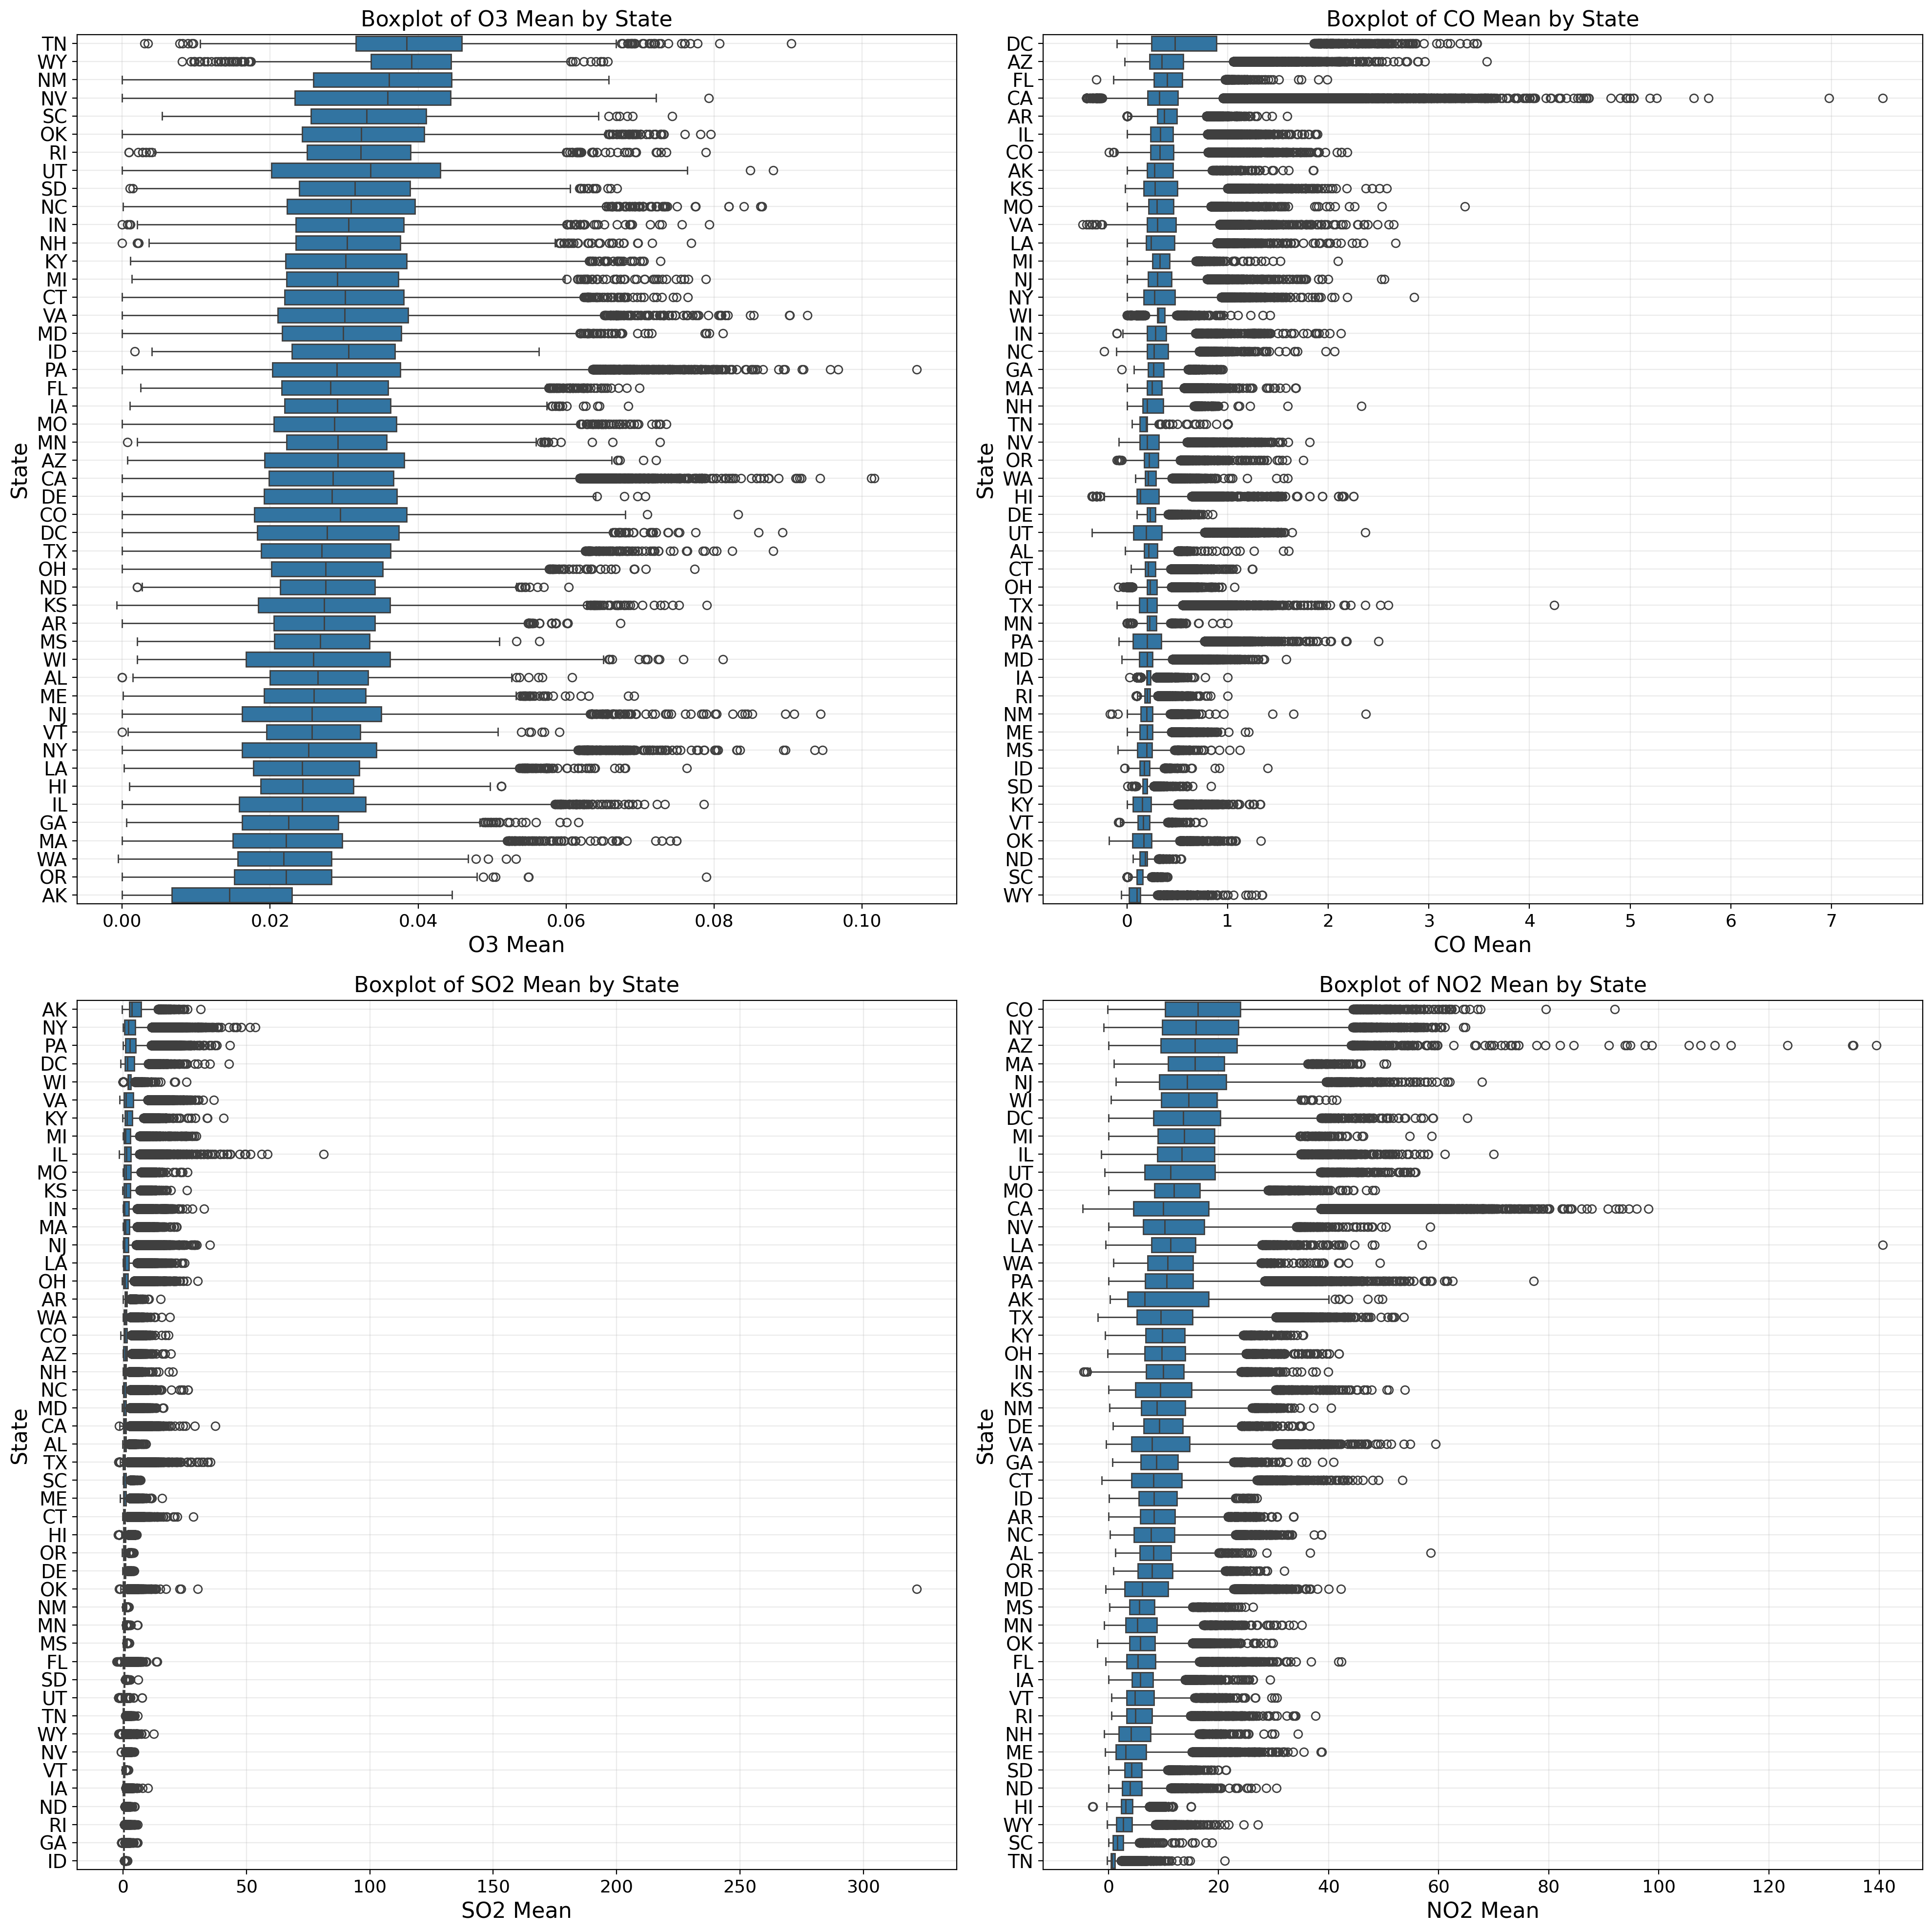

In [18]:
# Create the sorted boxplots
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.flatten()

for i, gas in enumerate(mean_columns[5:]):

    sorted_states = sort_states_by_aggregate(df, gas)

    sns.boxplot(y='State', x=gas, orient='h', data=df, order=sorted_states, ax=ax[i])
    ax[i].set_title(f"Boxplot of {gas} by State", fontsize=16)
    ax[i].set_ylabel("State", fontsize=16)
    ax[i].set_xlabel(gas, fontsize=16)
    ax[i].tick_params(axis='x', rotation=0, labelsize=13)
    ax[i].grid(alpha=0.25)
    ax[i].legend().remove()

plt.tight_layout()
plt.show()

In [19]:
def sort_states_by_aggregate(df: pd.DataFrame, column: str) -> List[str]:
    """
    Sorts states by the mean of a specified column in descending order.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to aggregate by.

    Returns:
        List[str]: A list of state abbreviations sorted by the aggregate value.
    """
    sorted_states = df.groupby('State')[column].mean().sort_values(ascending=False).index.tolist()
    return sorted_states

/tmp/ipython-input-3146829660.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()
/tmp/ipython-input-3146829660.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()
/tmp/ipython-input-3146829660.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()
/tmp/ipython-input-3146829660.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend().remove()


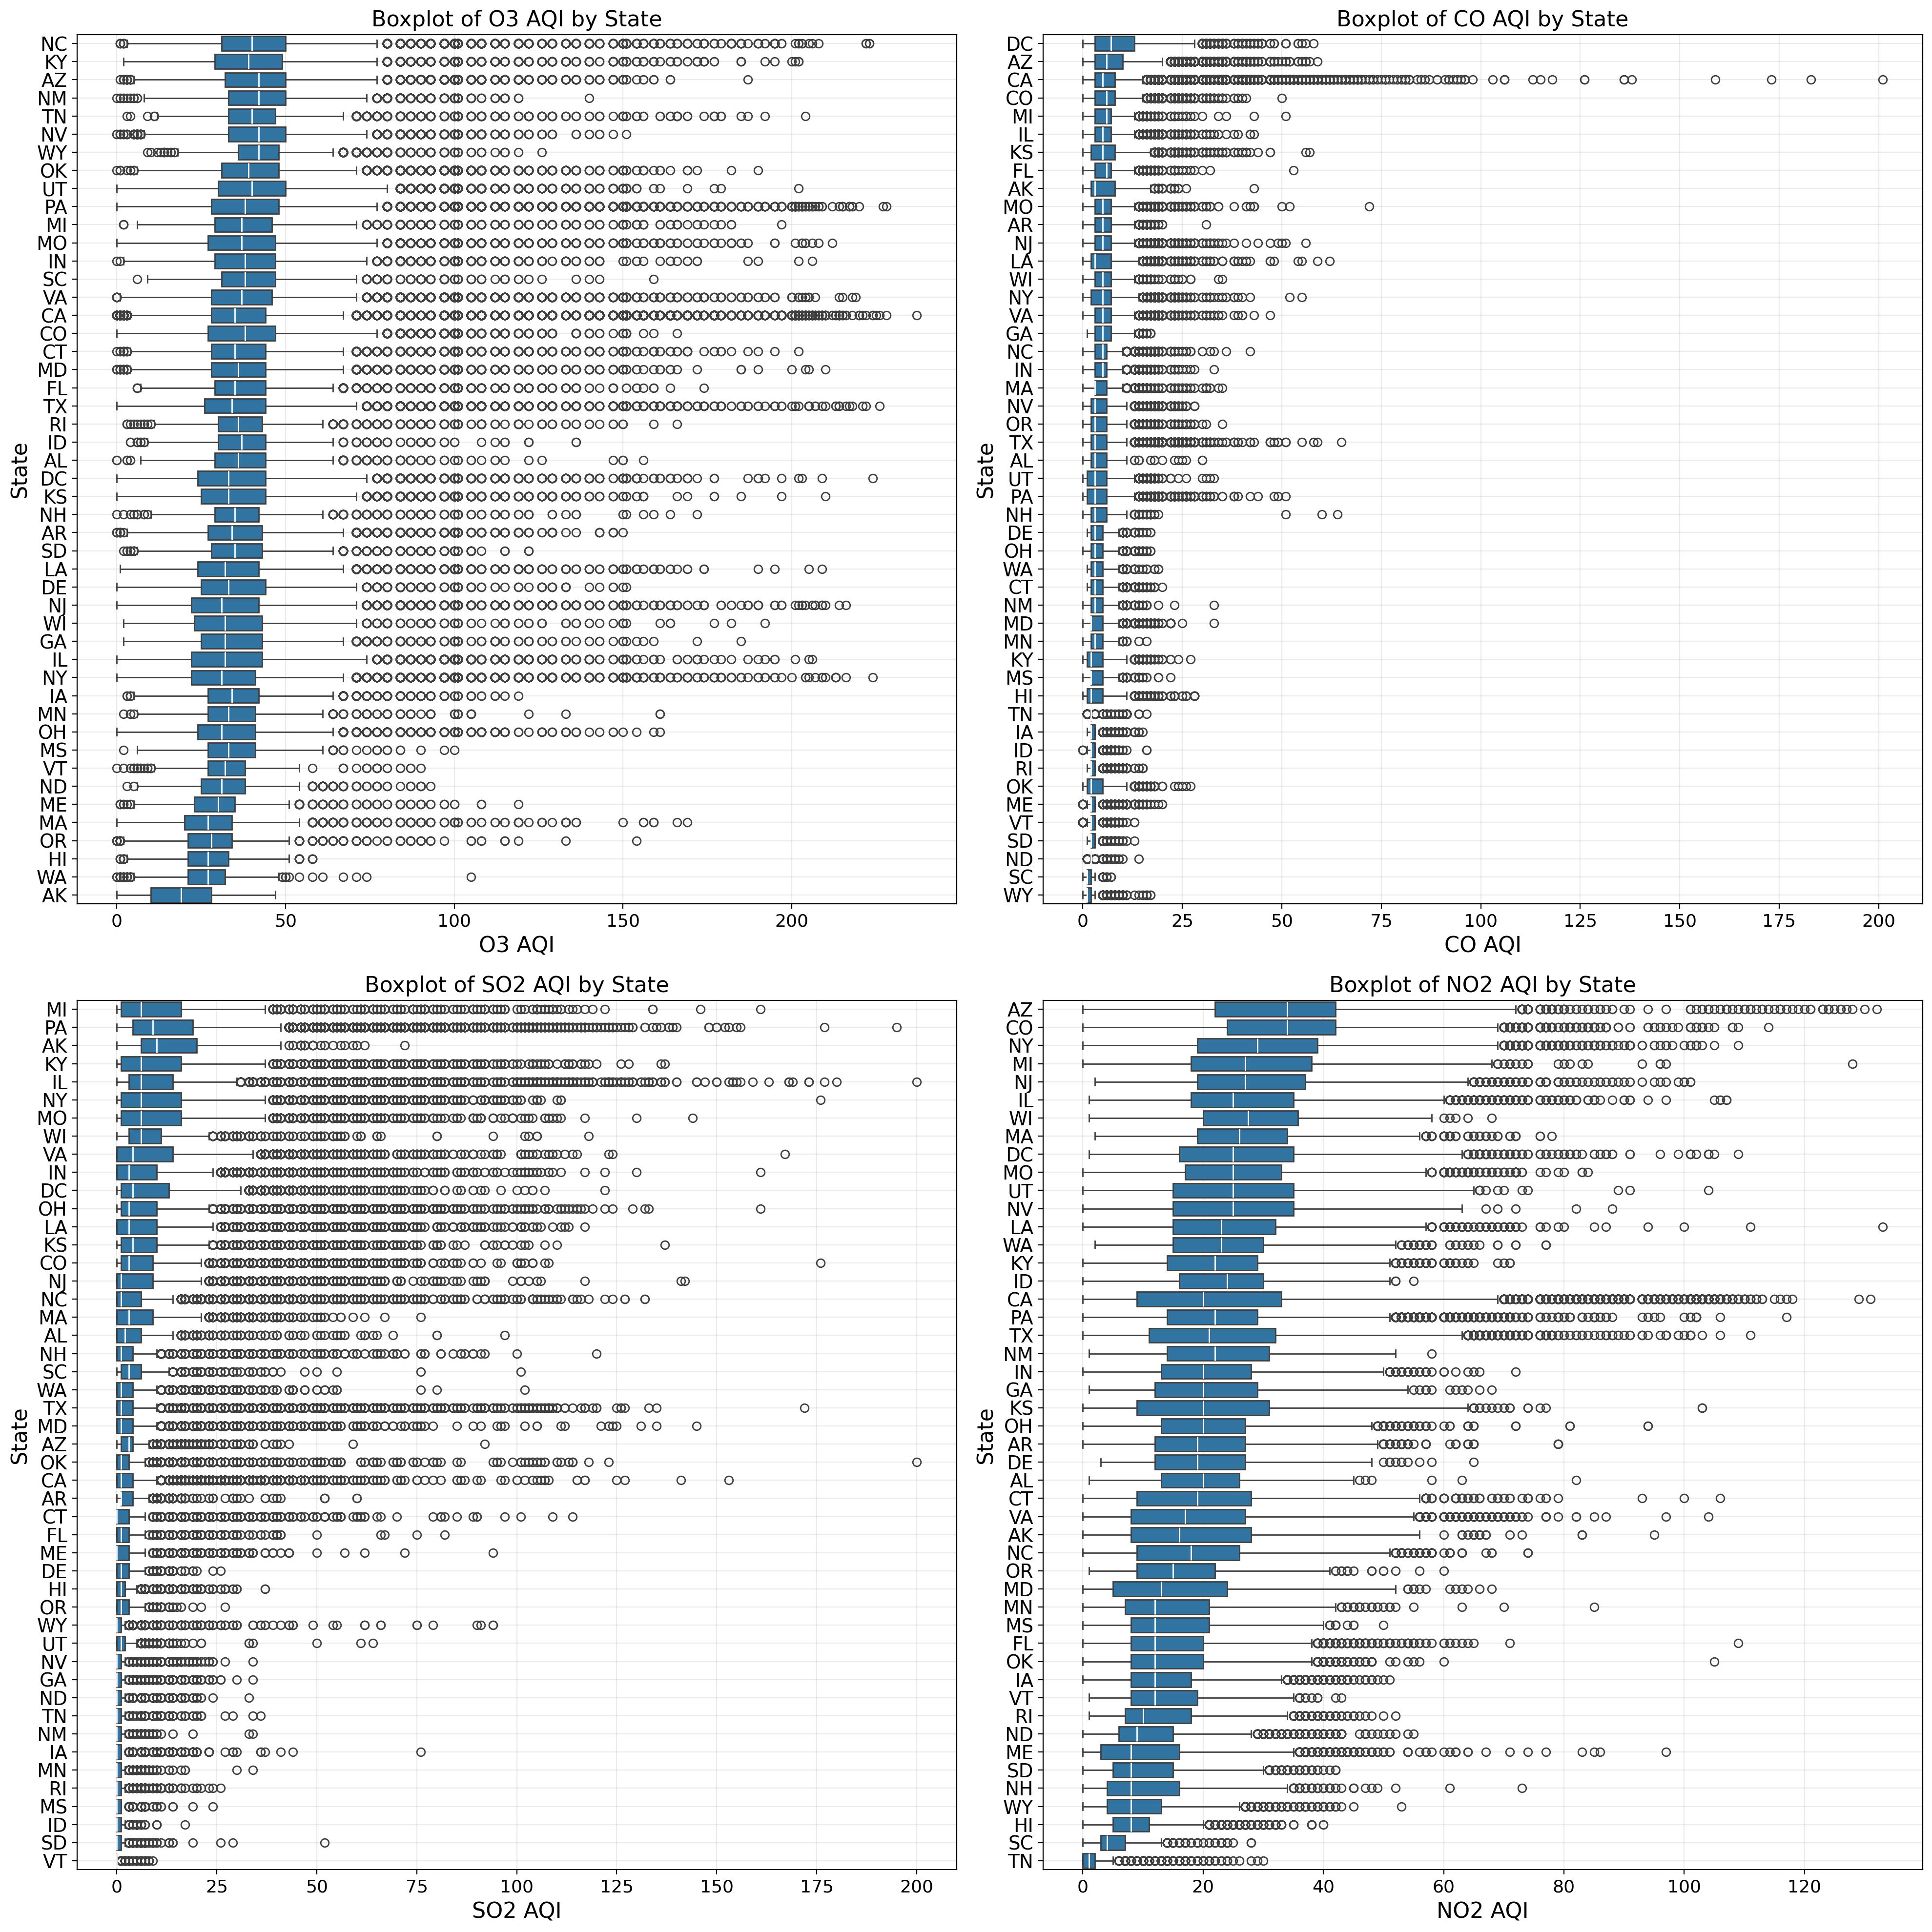

In [20]:
# Create the sorted boxplots for AQI
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.flatten()

for i, gas in enumerate(aqi_columns[5:]):

    sorted_states = sort_states_by_aggregate(df, gas)

    sns.boxplot(y='State', x=gas, orient='h', data=df, order=sorted_states, medianprops={'color': 'white'}, ax=ax[i])
    ax[i].set_title(f"Boxplot of {gas} by State", fontsize=16)
    ax[i].set_ylabel("State", fontsize=16)
    ax[i].set_xlabel(gas, fontsize=16)
    ax[i].tick_params(axis='x', rotation=0, labelsize=13)
    ax[i].grid(alpha=0.25)
    ax[i].legend().remove()

plt.tight_layout()
plt.show()

/tmp/ipython-input-2670739733.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='State', x='N_Address', data=df_n_addresses_per_state, ax=ax[0], palette='Greens_r')
/tmp/ipython-input-2670739733.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend().remove()
/tmp/ipython-input-2670739733.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='State', x='N_City', data=df_n_cities_per_state, ax=ax[1], palette='Blues_r')
/tmp/ipython-input-2670739733.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label star

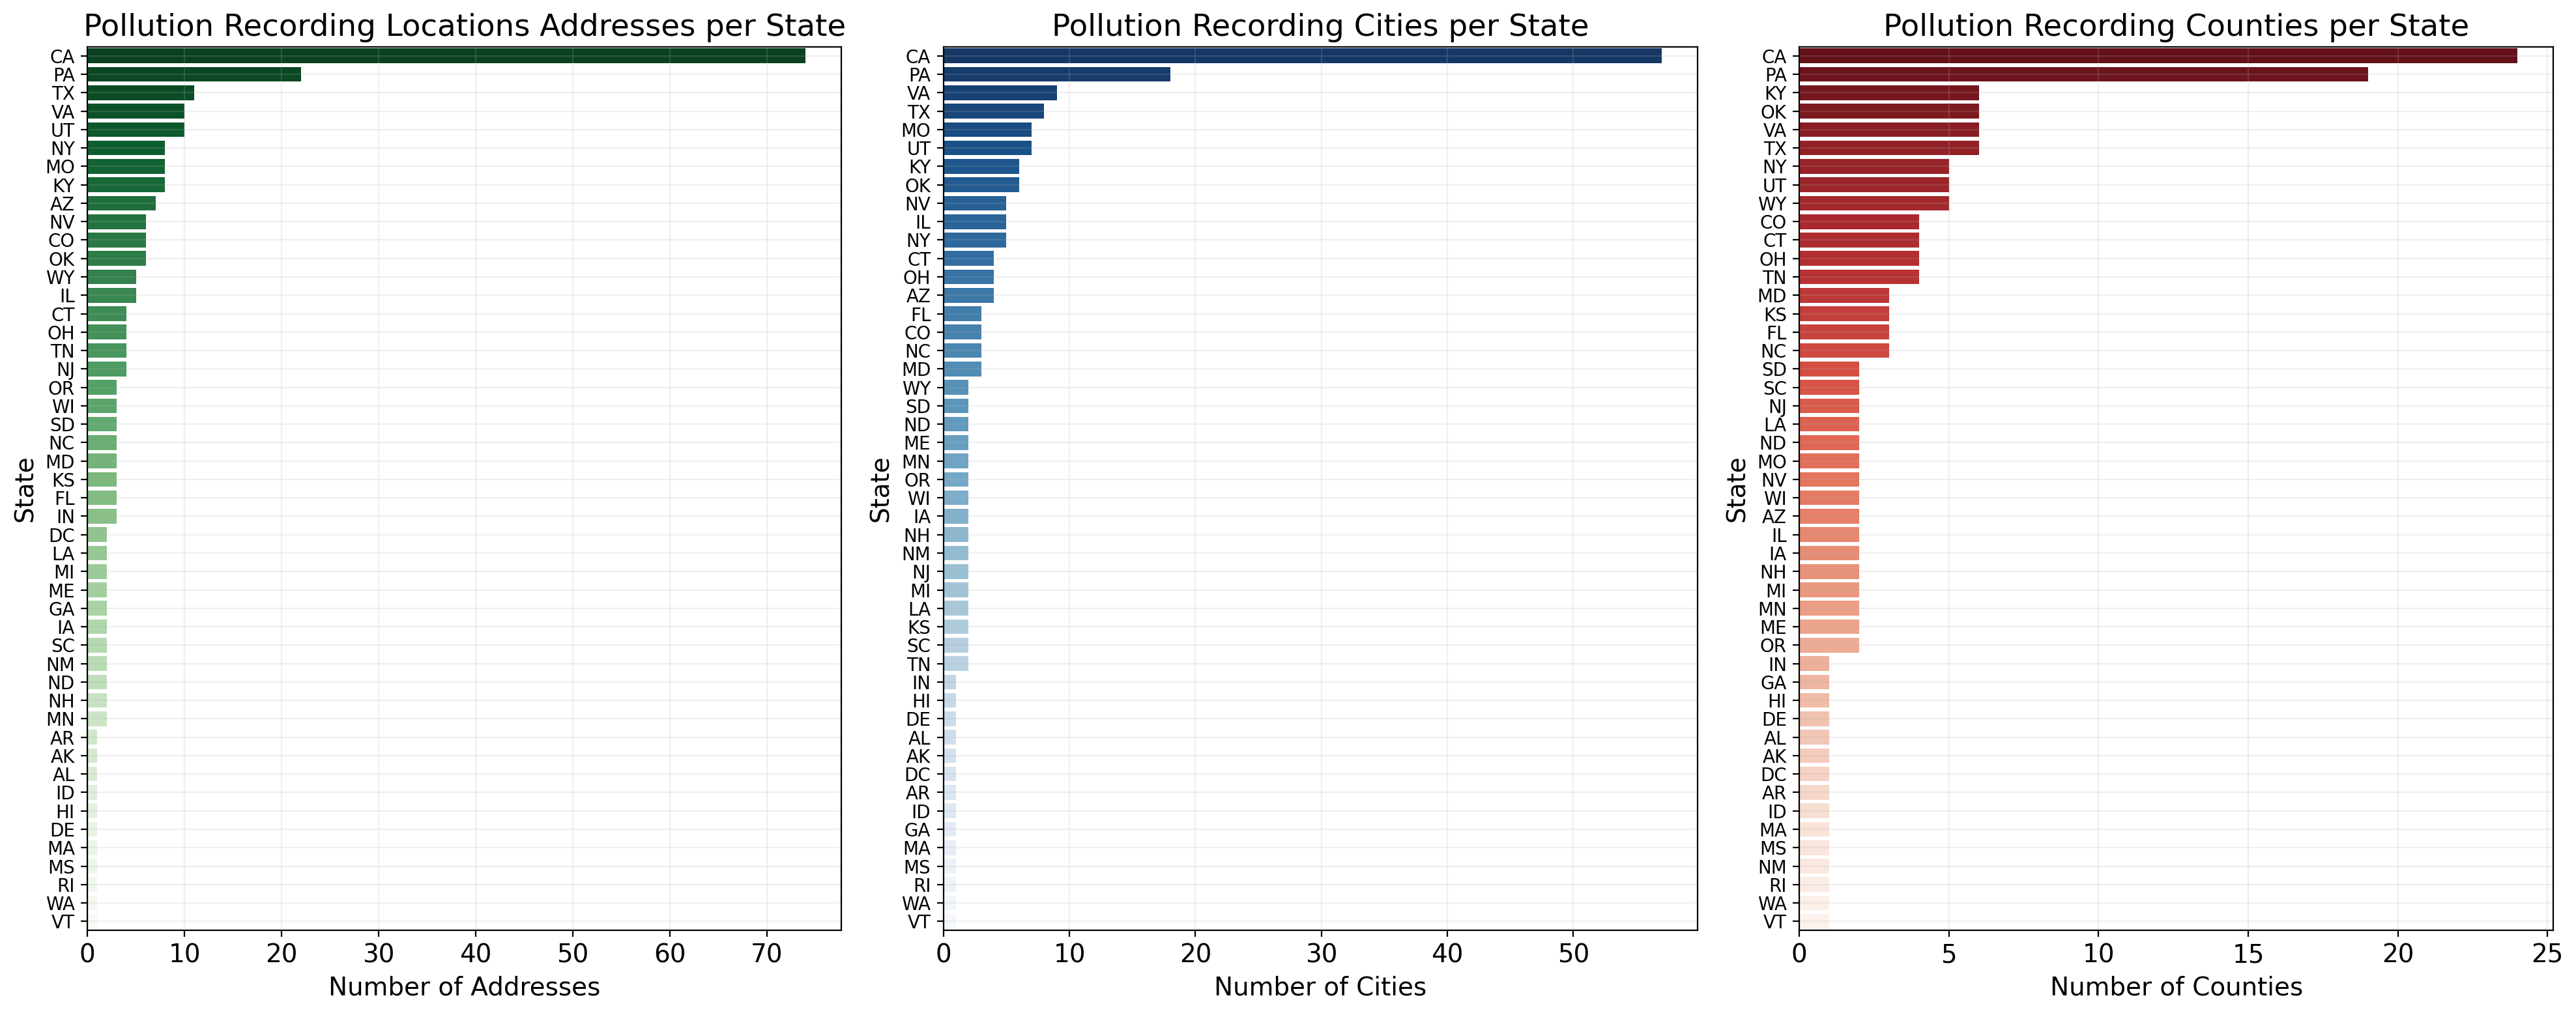

In [23]:
# Looking at number of Addresses where recording of air pollutants occurred
df_n_addresses_per_state = create_address_dataframe(df, ).sort_values(by='N_Address', ascending=False)
df_n_counties_per_state = create_address_dataframe(df, 'County').sort_values(by='N_County', ascending=False)
df_n_cities_per_state = create_address_dataframe(df, 'City').sort_values(by='N_City', ascending=False)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

# Number of Addresses per State
sns.barplot(y='State', x='N_Address', data=df_n_addresses_per_state, ax=ax[0], palette='Greens_r')
ax[0].set_xlabel('Number of Addresses')
ax[0].set_ylabel('State')
ax[0].set_title('Pollution Recording Locations Addresses per State')
ax[0].tick_params(axis='y', labelsize=10)
ax[0].grid(alpha=0.2)
ax[0].legend().remove()

# Number of Cities per State
sns.barplot(y='State', x='N_City', data=df_n_cities_per_state, ax=ax[1], palette='Blues_r')
ax[1].set_xlabel('Number of Cities')
ax[1].set_ylabel('State')
ax[1].set_title('Pollution Recording Cities per State')
ax[1].tick_params(axis='y', labelsize=10)
ax[1].grid(alpha=0.2)
ax[1].legend().remove()

# Number of Counties per State
sns.barplot(y='State', x='N_County', data=df_n_counties_per_state, ax=ax[2], palette='Reds_r')
ax[2].set_xlabel('Number of Counties')
ax[2].set_ylabel('State')
ax[2].set_title('Pollution Recording Counties per State')
ax[2].tick_params(axis='y', labelsize=10)
ax[2].grid(alpha=0.2)
ax[2].legend().remove()

plt.tight_layout()
plt.show()

In [22]:
def create_address_dataframe(df: pd.DataFrame, column: str = 'Address') -> pd.DataFrame:
    """
    Creates a DataFrame with the count of unique values in a specified column per state.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to count unique values for.

    Returns:
        pd.DataFrame: A DataFrame with states and the count of unique values in the specified column.
    """
    grouped = df.groupby('State')[column].nunique().reset_index()
    grouped.columns = ['State', f'N_{column.replace(" ", "_")}']
    return grouped

In [26]:
# Using above function to get yearly means per state
state_agg = compute_aggregations(df, numeric_columns, group_by_column='State', time_frame='Y', aggregation_func='max')
display(state_agg)

/tmp/ipython-input-1939894851.py:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  aggregated_df = df.groupby([group_by_column, pd.Grouper(key='Date', freq=time_frame)])[columns].agg(aggregation_func).reset_index()


State       Date   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI  \
0      AK 2014-12-31  0.030294             0.035               23      32   
1      AK 2015-12-31  0.042176             0.051               23      47   
2      AK 2016-12-31  0.033706             0.042               23      39   
3      AK 2017-12-31  0.044588             0.050               23      46   
4      AK 2018-12-31  0.041059             0.045               23      42   
..    ...        ...       ...               ...              ...     ...   
772    WY 2018-12-31  0.060412             0.069               23      97   
773    WY 2019-12-31  0.051412             0.061               23      71   
774    WY 2020-12-31  0.056000             0.066               23      87   
775    WY 2021-12-31  0.065647             0.078               23     126   
776    WY 2022-12-31  0.056412             0.062               23      74   

      CO Mean  CO 1st Max Value  CO 1st Max Hour  CO AQI   SO2 Mean  \
0    1.312500               1.9               23    22.0  22.595652   
1    1.854167               3.8               23    43.0  31.525000   
2    1.279167               2.1               23    24.0  22.321739   
3    1.441667               2.3               23    26.0  24.345833   
4    1.608333               2.0               23    23.0  24.973913   
..        ...               ...              ...     ...        ...   
772  0.391667               0.4               23     5.0   0.982609   
773  0.288235               0.4               23     5.0   3.076190   
774  0.587500               1.4               23    16.0   2.800000   
775  0.300000               0.3               23     3.0   1.995833   
776  0.212500               0.3               22     3.0   0.212500   

     SO2 1st Max Value  SO2 1st Max Hour  SO2 AQI   NO2 Mean  \
0                 34.5                23     49.0  28.995455   
1                 53.5                23     72.0  49.795833   
2                 45.8                23     62.0  35.509091   
3                 42.5                23     59.0  43.595455   
4                 43.8                23     60.0  49.056522   
..                 ...               ...      ...        ...   
772                9.5                23     13.0  18.200000   
773               12.4                23     17.0  16.770833   
774                3.7                23      4.0  15.616667   
775               11.2                23     16.0  14.937500   
776                0.3                22      3.0  12.245455   

     NO2 1st Max Value  NO2 1st Max Hour  NO2 AQI  
0                 95.1                23       95  
1                 84.9                23       83  
2                 69.3                23       67  
3                 65.7                23       63  
4                 69.1                23       67  
..                 ...               ...      ...  
772               44.6                23       42  
773               41.7                23       39  
774               42.6                23       40  
775               36.0                23       34  
776               35.9                23       33  

[777 rows x 18 columns]

In [25]:
def compute_aggregations(df: pd.DataFrame, columns: List[str], group_by_column: str, time_frame: Optional[str] = None, aggregation_func: Union[str, Callable] = 'mean') -> pd.DataFrame:
    """
    Computes aggregations for specified columns, grouping by a given column and optionally a time frame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (List[str]): A list of column names to aggregate.
        group_by_column (str): The column to group by.
        time_frame (Optional[str]): The time frame for resampling (e.g., 'Y' for yearly). Defaults to None.
        aggregation_func (Union[str, Callable]): The aggregation function to apply (e.g., 'mean', 'max', 'sum'). Defaults to 'mean'.

    Returns:
        pd.DataFrame: A DataFrame with the aggregated data.
    """
    if time_frame:
        aggregated_df = df.groupby([group_by_column, pd.Grouper(key='Date', freq=time_frame)])[columns].agg(aggregation_func).reset_index()
    else:
        aggregated_df = df.groupby(group_by_column)[columns].agg(aggregation_func).reset_index()

    return aggregated_df

In [27]:
# Your data and plotting code
column = 'O3 AQI'

fig = px.choropleth(
    state_agg,
    locations=state_agg['State'],
    locationmode='USA-states',
    color=column,
    projection='albers usa',
    animation_frame='Date',
    color_continuous_scale='greys',
    range_color=[state_agg['O3 AQI'].min(), state_agg['O3 AQI'].max()]
)

fig.update_layout(
    height=700,
    width=1100,
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=0, pad=4, autoexpand=True),
    coloraxis_colorbar=dict(title=f'Mean of {column}', xanchor='left', titleside='right')
)

# Show the plot
fig.show()

/tmp/ipython-input-1939894851.py:16: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

/tmp/ipython-input-2080068803.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2080068803.py:24: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

/tmp/ipython-input-2080068803.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2080068803.py:24: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



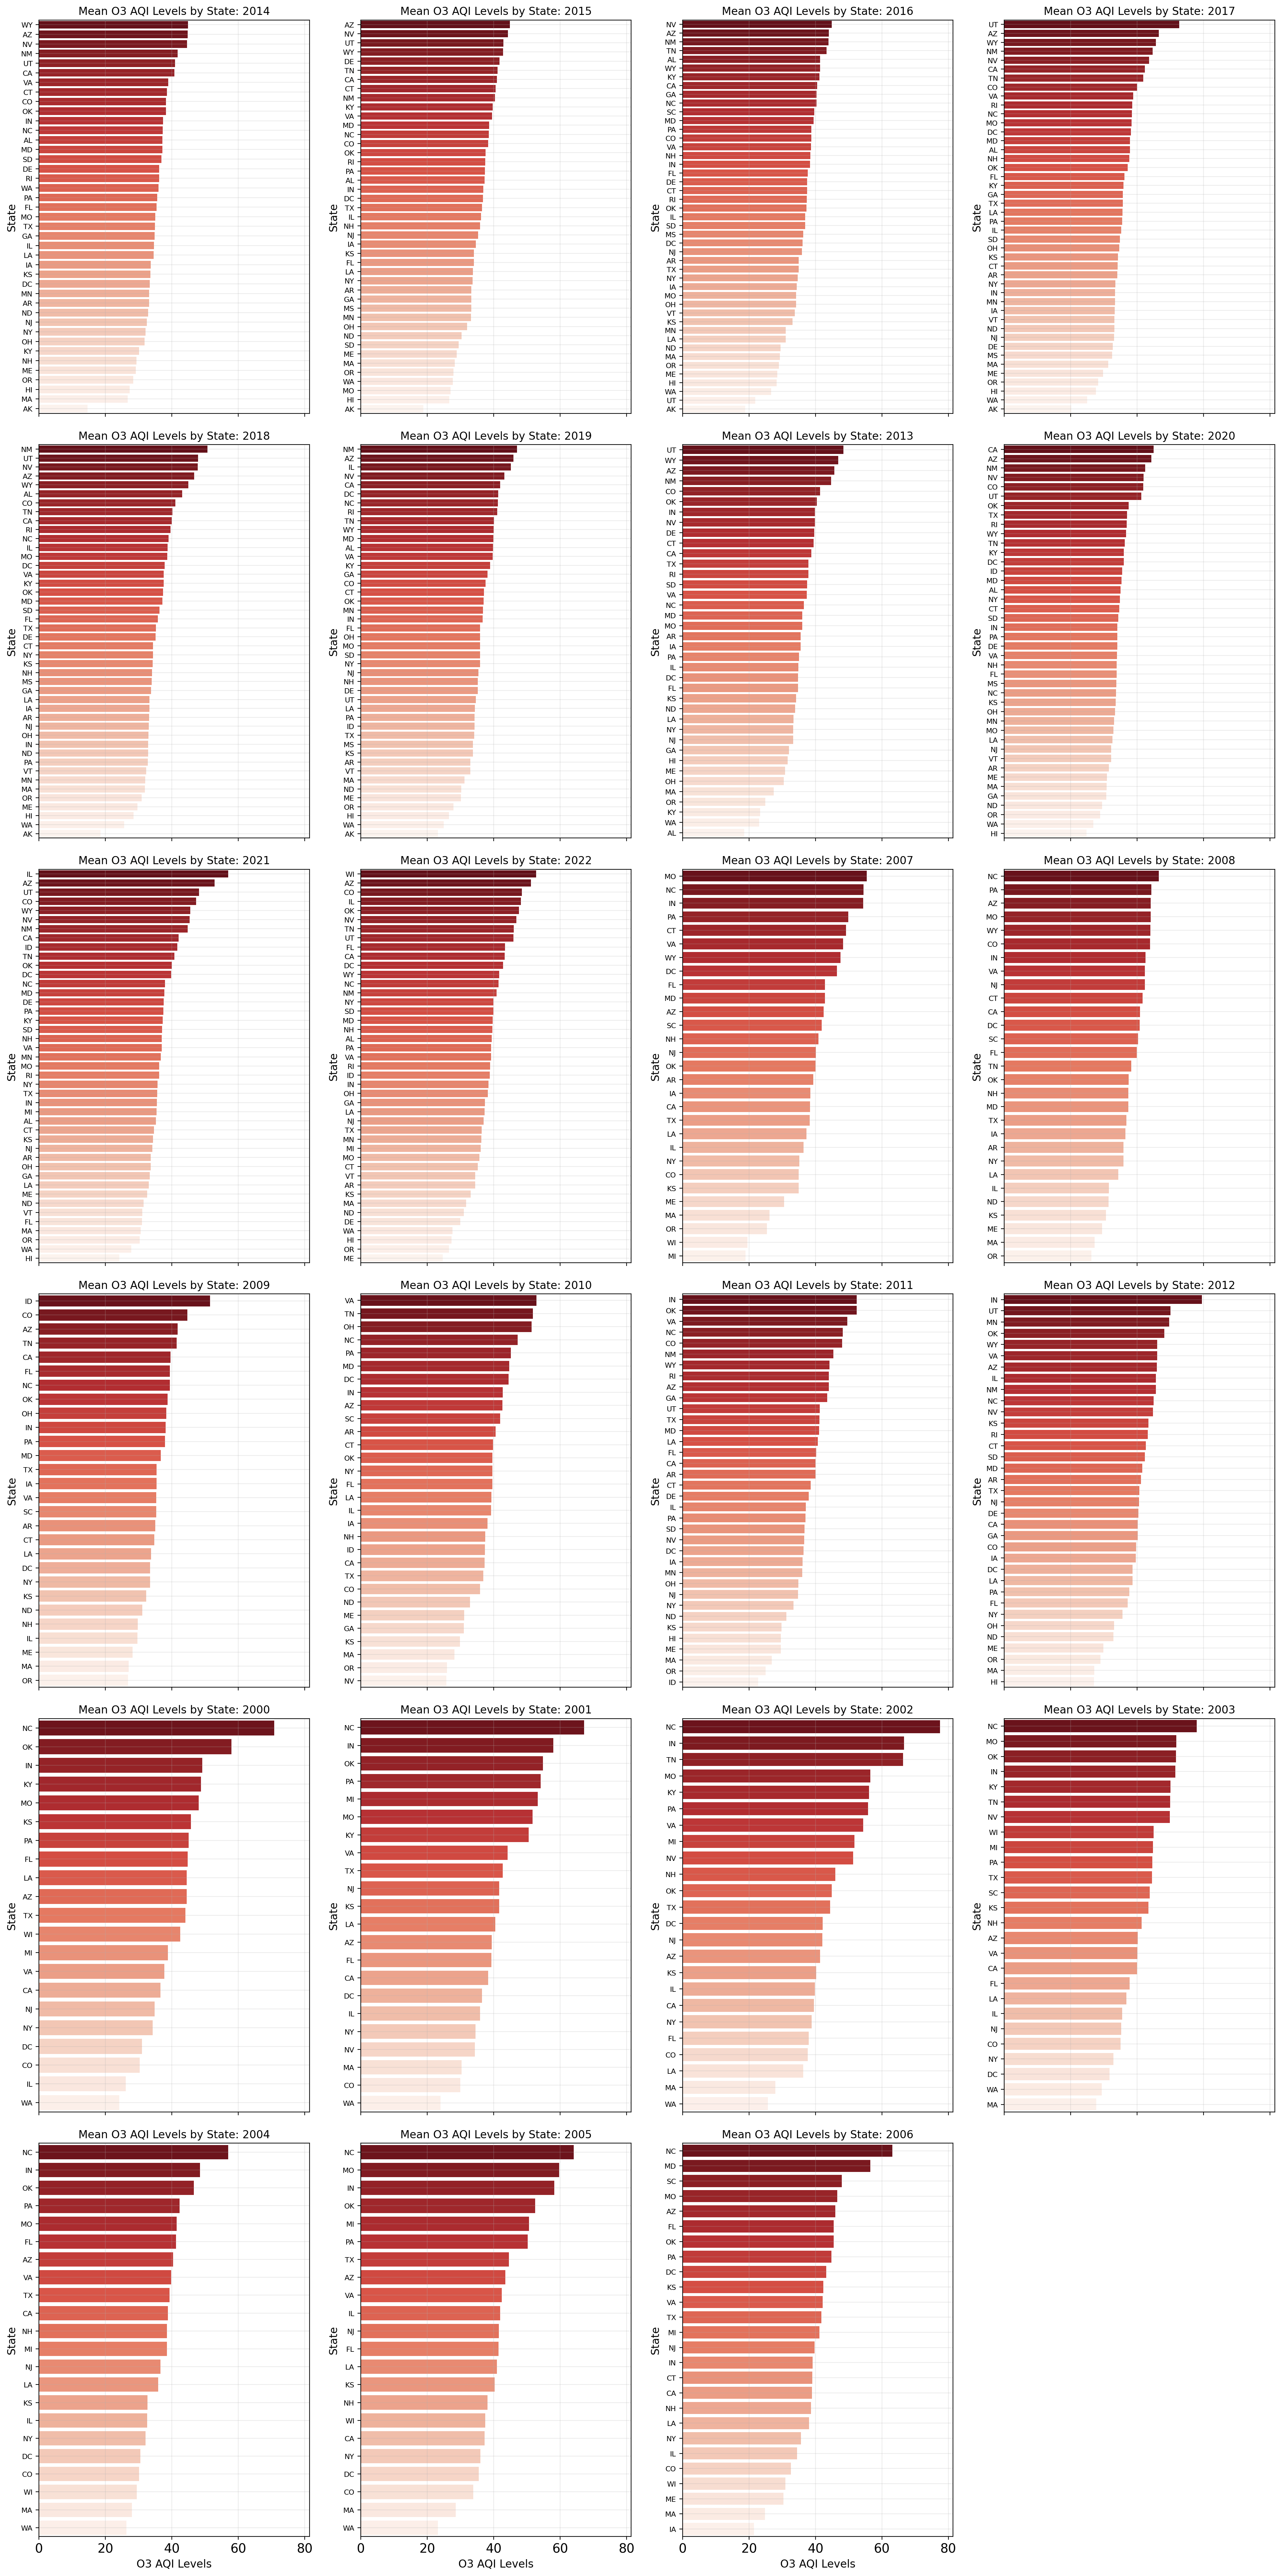

In [28]:
# Setting up plot
column = 'O3 AQI'
state_agg = compute_aggregations(df, numeric_columns, group_by_column='State', time_frame='Y', aggregation_func='mean')
state_years = state_agg['Date'].dt.year.unique()

# Plotting agg for each state by given column
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 40), sharex=True)
ax = ax.flatten()

for i, year in enumerate(state_years):

    grouped_data = state_agg[state_agg['Date'].dt.year == int(year)]

    sns.barplot(x=f'{column}',
                y=f'State',
                data=grouped_data.sort_values(f'{column}', ascending=False),
                palette="Reds_r",
                ax=ax[i],)
    ax[i].set_title(f'Mean {column} Levels by State: {year}', fontsize=12)
    ax[i].set_xlabel(f'{column} Levels', fontsize=12)
    ax[i].set_ylabel('State', fontsize=12)
    ax[i].tick_params(axis='y', labelsize=8)
    ax[i].grid(alpha=0.25)
    ax[i].legend().remove()

ax[23].axis('off')
plt.tight_layout()
plt.show()

In [29]:
# Grouping & calculate min/max years per group
year_range_df = df.groupby(['Address', 'State'])['Year'].agg(['min', 'max']).reset_index()
year_range_df = year_range_df[(year_range_df['min'] <= 2018) & (year_range_df['max'] == 2022)]

display(year_range_df.sort_values(by='min'))

# Filter df_agg_time to only include these groups
filtered_address_states = year_range_df[['Address', 'State', 'min', 'max']]
filtered_df_agg_time = pd.merge(df, filtered_address_states, on=['Address', 'State'], how='inner')

Address State   min   max
1                           10 ARKANSAS ST.    CA  2000  2022
7       1029 ETHEL ST, CALEXICO HIGH SCHOOL    CA  2000  2022
11                     1061-A Leesville Ave    LA  2000  2022
19                       1130 EASTWAY DRIVE    NC  2000  2022
23   1210 N. 10TH ST.,JFK RECREATION CENTER    KS  2000  2022
..                                      ...   ...   ...   ...
48                       1810 N 16TH STREET    ND  2016  2022
134                        533 First Street    CA  2016  2022
118                          4250 Karen Ave    NV  2017  2022
25                     1250 NORTH 1400 WEST    UT  2018  2022
177                      8449 S. Monroe St.    UT  2018  2022

[77 rows x 4 columns]

In [32]:
# Applying function group_linregress
linregress_by_address_df = group_linregress(filtered_df_agg_time,
                                            date_col='Date',
                                            by=['Address', 'State'],
                                            columns=numeric_columns)

# Showing function dataframe
display(linregress_by_address_df.head())

Address State            Column         Slope  Intercept   R_Value  \
0  10 ARKANSAS ST.    CA           O3 Mean  8.190395e-07   0.019172  0.159289   
1  10 ARKANSAS ST.    CA  O3 1st Max Value  6.663267e-07   0.025128  0.130496   
2  10 ARKANSAS ST.    CA   O3 1st Max Hour -2.322288e-05  12.016607 -0.008919   
3  10 ARKANSAS ST.    CA            O3 AQI  6.189970e-04  23.269332  0.129902   
4  10 ARKANSAS ST.    CA           CO Mean -5.873704e-05   0.679293 -0.424867   

         P_Value       Std_Err  
0   2.726221e-21  8.590181e-08  
1   9.633138e-15  8.566884e-08  
2   5.981593e-01  4.405802e-05  
3   1.273381e-14  7.995380e-05  
4  3.520874e-153  2.117838e-06

In [31]:
def group_linregress(df: pd.DataFrame, date_col: str, by: List[str], columns: List[str]) -> pd.DataFrame:
    """
    Performs linear regression for multiple columns within groups of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_col (str): The name of the date column.
        by (List[str]): A list of column names to group by.
        columns (List[str]): A list of column names to perform linear regression on.

    Returns:
        pd.DataFrame: A DataFrame containing the results of the linear regression for each group and column.
    """
    results = []
    for name, group in df.groupby(by):
        group = group.copy()
        group[date_col] = (group[date_col] - group[date_col].min()).dt.days
        for col in columns:
            if len(group[date_col].unique()) > 1 and group[col].std() > 0:
                slope, intercept, r_value, p_value, std_err = linregress(group[date_col], group[col])
                results.append(list(name) + [col, slope, intercept, r_value, p_value, std_err])

    result_df = pd.DataFrame(results, columns=by + ['Column', 'Slope', 'Intercept', 'R_Value', 'P_Value', 'Std_Err'])
    return result_df

In [33]:
# Applying function group_linregress
linregress_by_address_df = group_linregress(filtered_df_agg_time,
                                            date_col='Date',
                                            by=['Address', 'State'],
                                            columns=numeric_columns)

# Showing function dataframe
display(linregress_by_address_df.head())

Address State            Column         Slope  Intercept   R_Value  \
0  10 ARKANSAS ST.    CA           O3 Mean  8.190395e-07   0.019172  0.159289   
1  10 ARKANSAS ST.    CA  O3 1st Max Value  6.663267e-07   0.025128  0.130496   
2  10 ARKANSAS ST.    CA   O3 1st Max Hour -2.322288e-05  12.016607 -0.008919   
3  10 ARKANSAS ST.    CA            O3 AQI  6.189970e-04  23.269332  0.129902   
4  10 ARKANSAS ST.    CA           CO Mean -5.873704e-05   0.679293 -0.424867   

         P_Value       Std_Err  
0   2.726221e-21  8.590181e-08  
1   9.633138e-15  8.566884e-08  
2   5.981593e-01  4.405802e-05  
3   1.273381e-14  7.995380e-05  
4  3.520874e-153  2.117838e-06

In [34]:
# Sort by values per AQI column type
# Data objects & slope lists
slopes_list = []

# Storing slopes by addresses by each AQI
for i, n_col in enumerate(aqi_columns[5:]):

    df_slope = linregress_by_address_df[linregress_by_address_df['Column'] == n_col]
    df_slope_sorted = df_slope.sort_values(by='Slope', ascending=False)
    slopes_list.append(df_slope_sorted.reset_index(drop=True))

# Showing important O3 AQI data
display(slopes_list[0].head(5))

Address State  Column     Slope  Intercept  \
0                      4545 Navajo St.    CO  O3 AQI  0.004142  35.504163   
1                        2105 BROADWAY    CO  O3 AQI  0.002928  25.328173   
2                      750 DUNDEE ROAD    IL  O3 AQI  0.002707  31.735872   
3                    3174 E. 78TH AVE.    CO  O3 AQI  0.001471  34.355278   
4  2500 1ST STREET, N.W. WASHINGTON DC    DC  O3 AQI  0.001462  34.579776   

    R_Value       P_Value   Std_Err  
0  0.173905  3.142456e-20  0.000446  
1  0.287654  7.381647e-89  0.000143  
2  0.171779  2.610702e-27  0.000248  
3  0.171369  2.262333e-49  0.000099  
4  0.097678  6.687865e-11  0.000223

In [36]:
# 1st Study
address_A = slopes_list[0].iloc[0][['Address', 'State']].tolist()
A = df['Address'] == address_A[0]
A_lm = slopes_list[0][(slopes_list[0]['Address'] == address_A[0]) & (slopes_list[0]['State'] == address_A[1])]
print(f'State: {address_A[1]}')
print(f'Address: {address_A[0]}')

State: CO
Address: 4545 Navajo St.


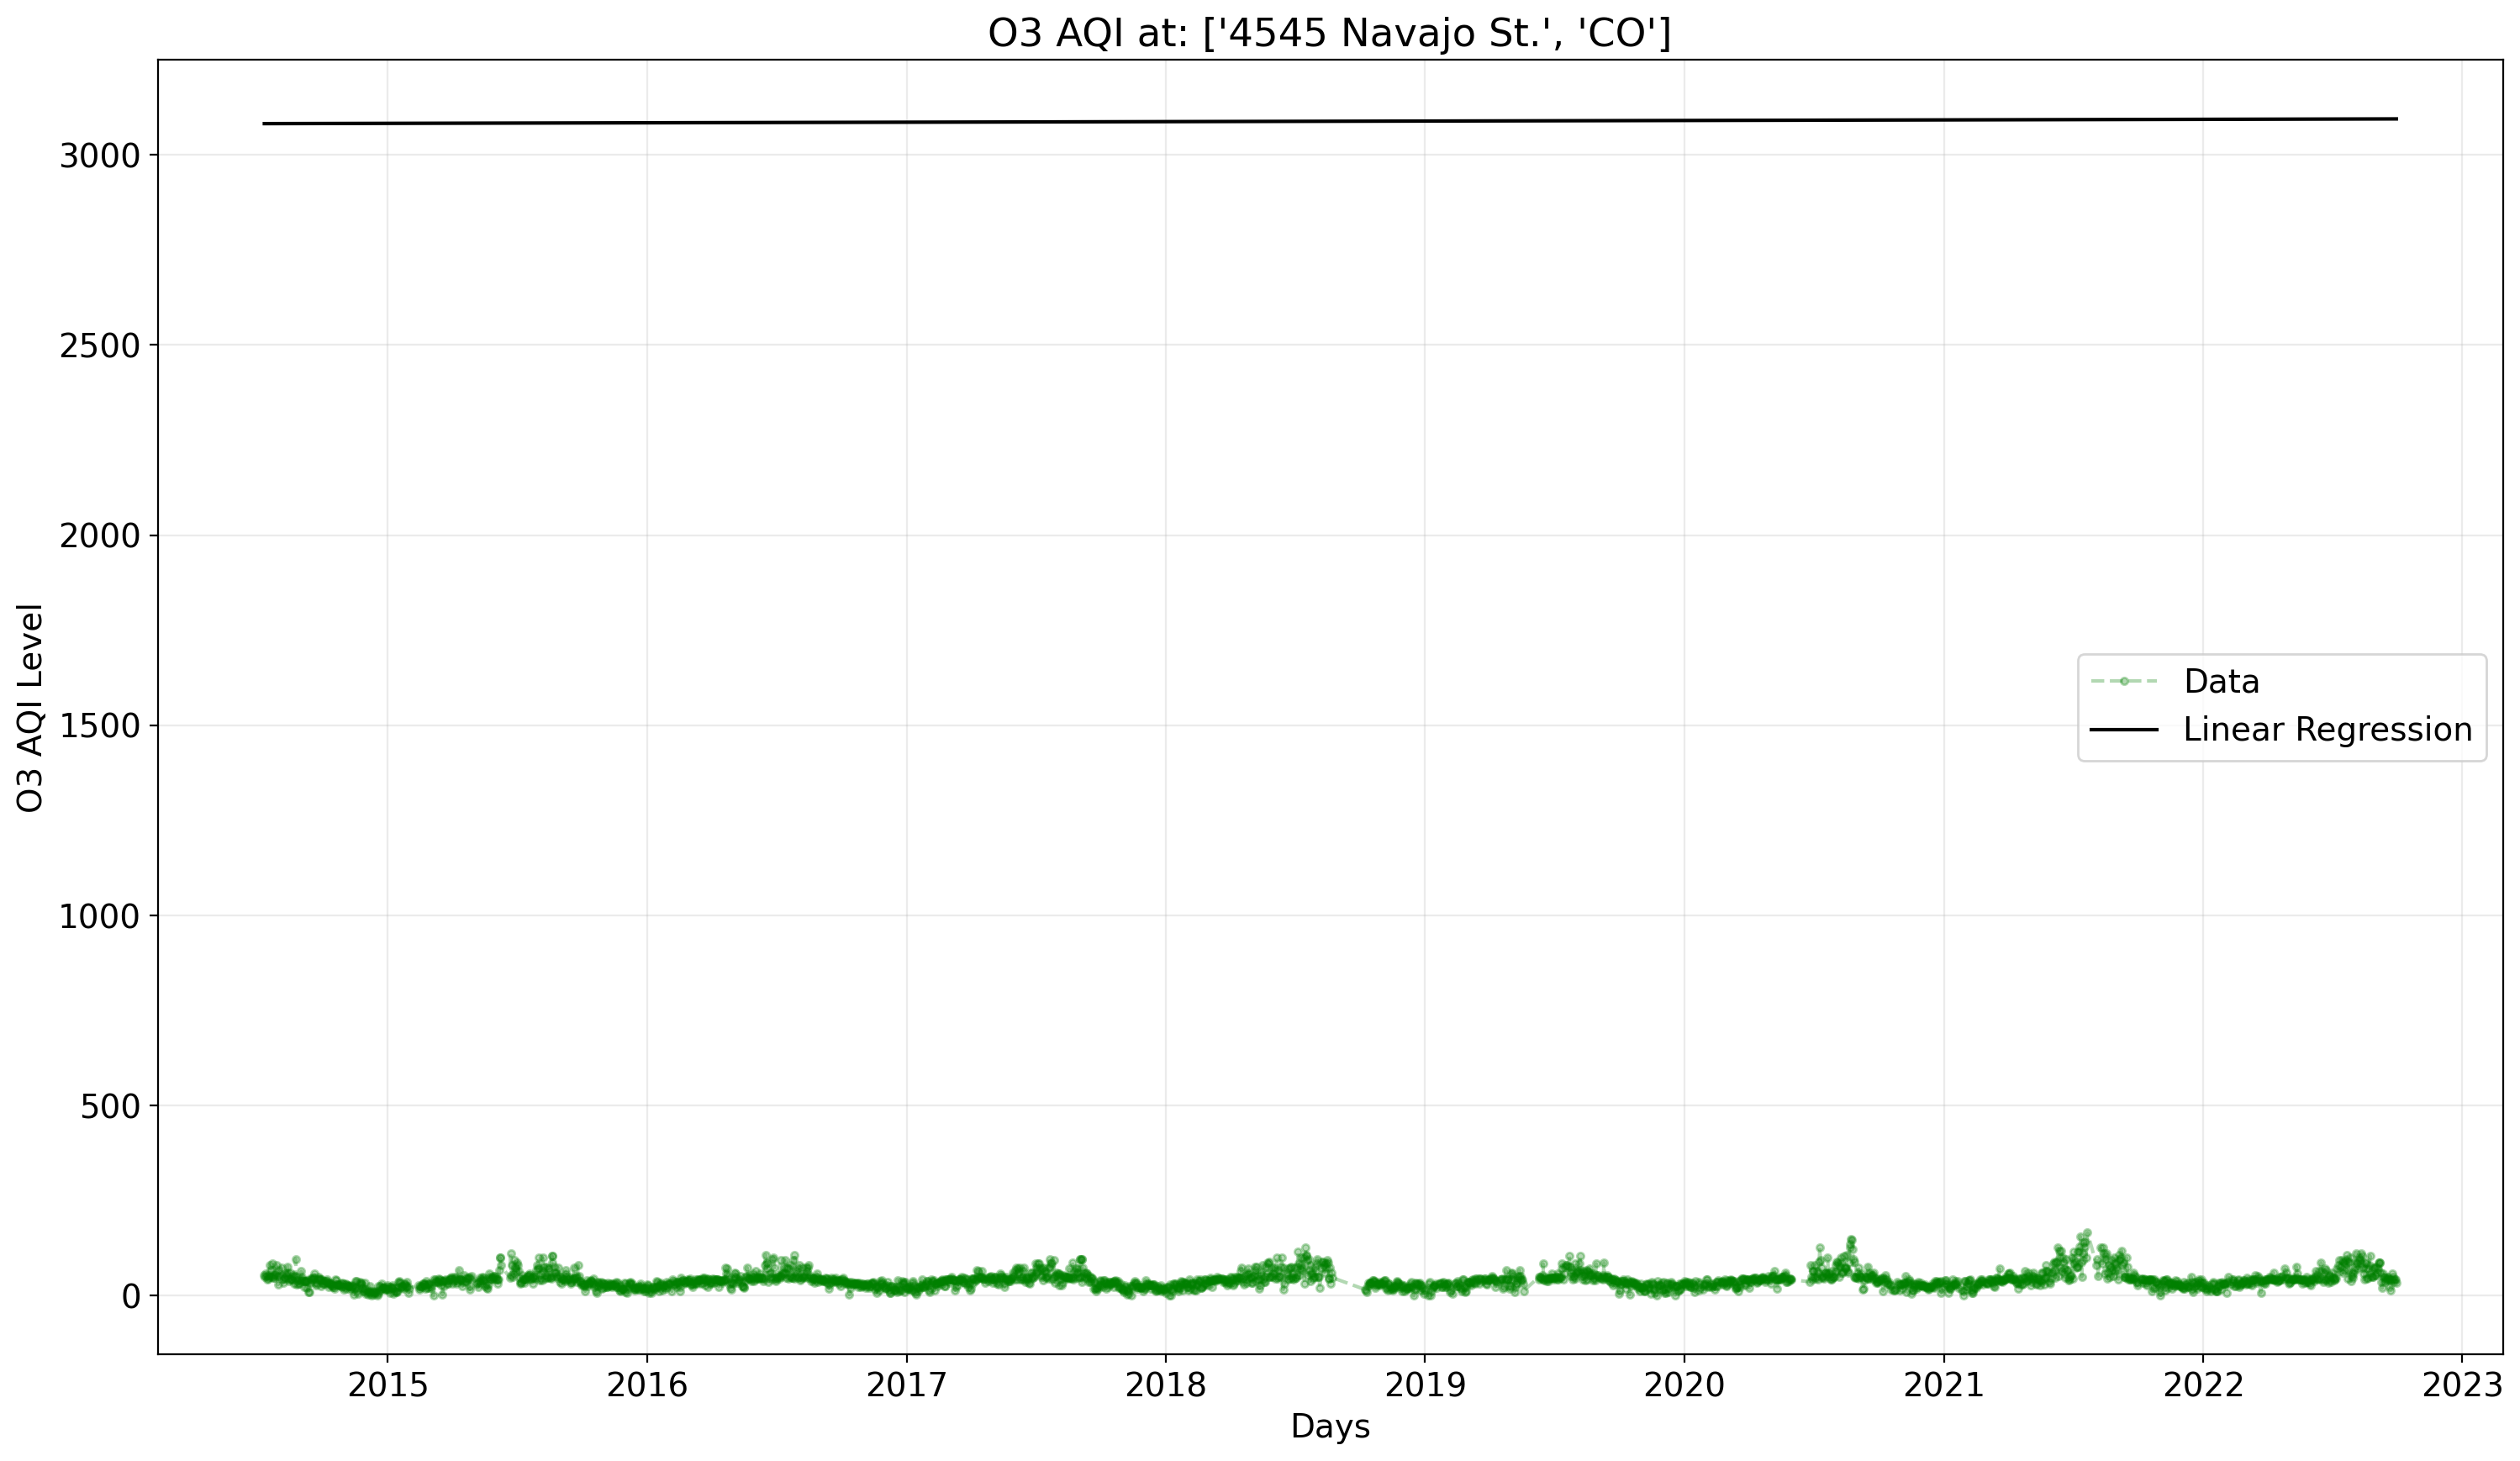

In [37]:
# Converting date index to numeric
df['Date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda x: x.toordinal())

# CA
lr_A_vals = df[A].Date_ordinal*A_lm['Slope'].values + A_lm['Intercept'].values
plt.plot(df[A]['Date'], df[A]['O3 AQI'], color='green', marker='.', linestyle='dashed', alpha=0.3, label='Data')
plt.plot(df[A]['Date'], lr_A_vals, color='k', label='Linear Regression')
plt.title(f'O3 AQI at: {address_A}')
plt.ylabel('O3 AQI Level')
plt.xlabel('Days')
plt.grid(alpha=0.25)
plt.legend()
plt.show()

State: DC
Address: 2500 1ST STREET, N.W. WASHINGTON DC


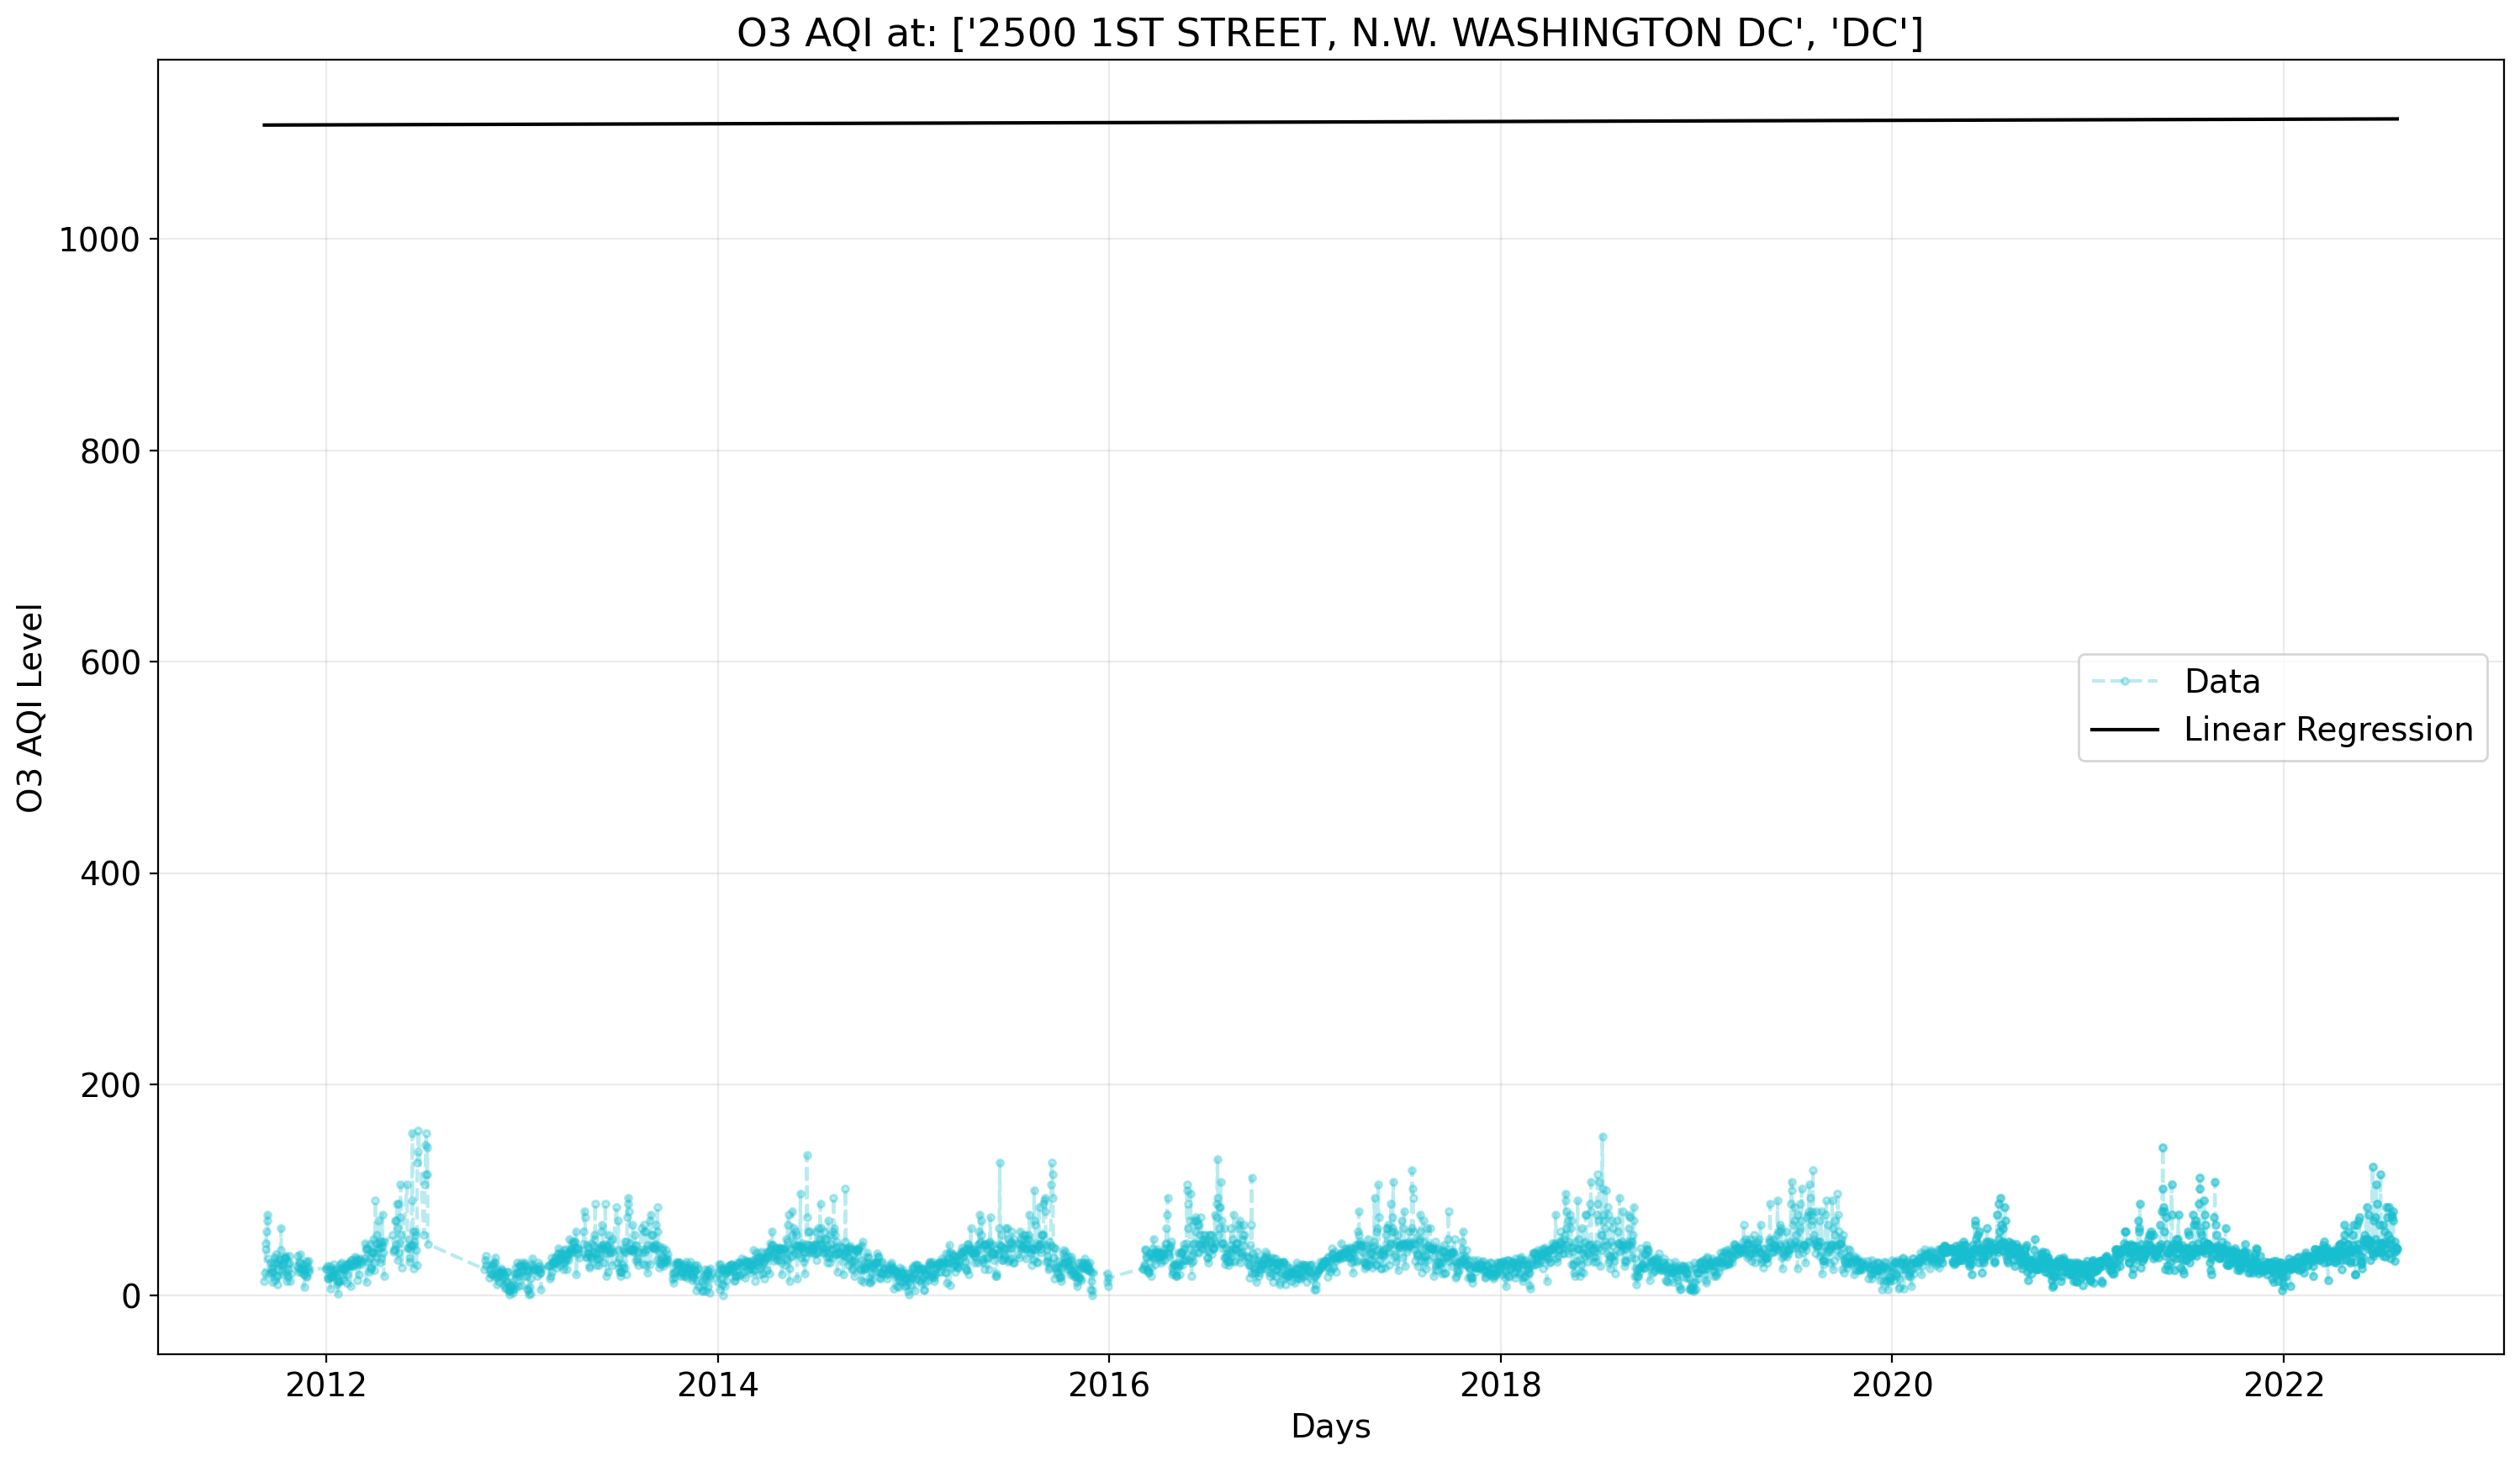

In [39]:
# 2nd Study
address_B = slopes_list[0].iloc[4][['Address', 'State']].tolist()
B = df['Address'] == address_B[0]
B_lm = slopes_list[0][(slopes_list[0]['Address'] == address_B[0]) & (slopes_list[0]['State'] == address_B[1])]
print(f'State: {address_B[1]}')
print(f'Address: {address_B[0]}')
# State: DC # Commented out to fix SyntaxError
# Address: 2500 1ST STREET, N.W. WASHINGTON DC # Commented out to fix SyntaxError
# PA # Commented out to fix SyntaxError
lr_B_vals = B_lm['Slope'].values*df[B].Date_ordinal + B_lm['Intercept'].values
plt.plot(df[B]['Date'], df[B]['O3 AQI'], color='C9', marker='.', linestyle='dashed', alpha=0.3, label='Data')
plt.plot(df[B]['Date'], lr_B_vals, color='k', label='Linear Regression')
plt.title(f'O3 AQI at: {address_B}')
plt.ylabel('O3 AQI Level')
plt.xlabel('Days')
plt.grid(alpha=0.25)
plt.legend()
plt.show()

6 | Conclusion ¶
6.1 Problem Statement and Objectives
The project aims to analyze recent spikes in ground-level ozone (O3) AQI levels at specific addresses within regions that have experienced significant pollution increases.

6.2 Key Findings
Regional Hotspots: Colorado and the District of Columbia emerged as regions needing immediate attention due to rising O3 levels.
Correlations: A positive correlation between O3 and NO2 indicates that mitigating one could affect the other, a useful insight for policy measures.
6.3 Justification for Address Selection
Addresses 4545 Navajo St., CO and 2500 1ST STREET, N.W. WASHINGTON DC were selected based on data quality and the significant increases in O3 and AQI levels observed.

6.4 Data Characteristics
Seasonality: Time series plots revealed seasonal trends, implying the need for seasonal models.
Distribution: Zero-inflated data suggests the potential use of log transformations.
6.5 Future Goals and Modeling Objectives
Comprehensive EDA: Before proceeding with any modeling, we will perform a detailed exploration of the data at these specific locations to understand the underlying patterns in these regions. Additionally, we will consider transforming the data based on their underlying distributions.
Objectives:
Data Distributions: A deeper examination of data distributions will be conducted.
Seasonal and Temporal Trend Evaluation: We will assess how pollution levels vary throughout different times of the day and year.
Modeling:
ARIMA: To capture long-term trends in AQI levels.
SARIMAX: To account for seasonality and other external factors.
Bayesian Structural Time Series: To identify any sudden structural shifts in AQI levels.
Modeling Objective: The main goal is to identify the best-performing model through a train-test split methodology. The selected model will then be employed for forecasting future O3 levels at the targeted addresses, thereby informing potential regulatory interventions.
By merging these objectives and methodologies, we aim to establish a robust framework for understanding and mitigating the rise in pollutant levels, particularly O3, at these specific addresses.